# Trapping SINDy
By Alan Kaptanoglu and Jared Callaham

This example illustrates the use of a new "trapping SINDy" extension on a number of canonical fluid systems. The algorithm searches for globally stable systems with energy-preserving quadratic nonlinearities. This builds off of the new constrained SINDy algorithm based on SR3. The trapping theorem for stability utilized in this SINDy algorithm can be found in Schlegel, M., & Noack, B. R. (2015). On long-term boundedness of Galerkin models. Journal of Fluid Mechanics, 765, 325-352. 

In [1]:
# Import libraries. Note that the neksuite (pymech)
# package is required for visualization of the 
# vortex shedding example
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import scipy.io as sio

# Comment out below lines if not doing the vortex shedding
import sys
sys.path.append('/media/akaptano/HITSI-Work/pysindy/examples/data/pod_mean/')
import neksuite as nek

In [2]:
# Define some setup and plotting functions


# Build the energy-preserving quadratic nonlinearity constraints
def make_constraints(r):
    q = 0
    Nr = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * Nr))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (Nr - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (Nr - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (Nr - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    

# Make the projection tensors used for the algorithm
def make_Ptensor(r):
    Nr = int((r ** 2 + 3 * r) / 2.0)

    # delta_{il}delta_{jk}
    PL_tensor = np.zeros((r, r, r, Nr))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(Nr):
                    if i == l and j == k:
                        PL_tensor[i, j, k, l] = 1.0

    # Now symmetrize PL
    for i in range(r):
        for j in range(Nr):
            PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

    PQ_tensor = np.zeros((r, r, Nr))
    for i in range(r):
        # Off diagonal terms
        for j in range(i+1, r):
            PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0  # opt_m[k]  

        # diagonal terms
        PQ_tensor[i, i, Nr - r + i] = 1.0  # opt_m[j]

    # Now symmetrize PQ
    for j in range(Nr):
        PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
        
    return PL_tensor, PQ_tensor


# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, sindy_opt):
    Nr = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor = sindy_opt.PL
    PQ_tensor = sindy_opt.PQ
    mPQ = np.zeros(PL_tensor.shape)
    for i in range(r):
        for j in range(i + 1, r):
            mPQ[i, j, :, int((i + 1) / 2.0 * (2 * r - i)) + j - 1 - i] = opt_m
    for i in range(r):
        mPQ[i, i, :, Nr - r + i] = opt_m
    for i in range(r):
        for j in range(Nr):
            mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    smallest_eigval = np.sort(eigvals)[-1]
    largest_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([2], [0]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.sqrt(smallest_eigval / largest_eigval) * np.linalg.norm(d)
    print('d = ', d)
    print('Rm = ', Rm)
    

# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    print(dW.shape, dM.shape)
    plt.semilogy(dW)
    plt.semilogy(dM)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure(figsize=(8, 14))
    for j in range(r):
        plt.subplot(r, 1, j + 1)
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j])
        else:
            plt.plot(PWeigs[:, j])
    

# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'b--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'b--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')
    

# Make a bar plot of the distribution of SINDy coefficients
# and distribution of Galerkin coefficients for the von Karman street
def make_bar(galerkin9, L, Q):
    bins = np.logspace(-11, 0, 50)
    plt.figure(figsize=(8, 8))
    plt.grid('True')
    galerkin_full = np.vstack((galerkin9['L'].reshape(r ** 2, 1), 
                               galerkin9['Q'].reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(galerkin_full), bins=bins)
    sindy_full = np.vstack((L.reshape(r ** 2, 1), 
                            Q.reshape(len(galerkin9['Q'].flatten()), 1)))
    plt.hist(np.abs(sindy_full.flatten()), bins=bins, color='k')
    plt.xscale('log')
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_yticks([0, 20, 40, 60, 80])
    plt.savefig('vonKarman_sparsity.pdf')


# Make Lissajou figures with ground truth and SINDy model on both training and test data
def make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, filename):
    fig = plt.figure(figsize=(18, 18))
    spec = gridspec.GridSpec(ncols=r, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(0, r):
        for j in range(i, r):
            plt.subplot(spec[i, j])
            plt.plot(x_train[:, i], x_train[:, j],linewidth=1)
            plt.plot(x_train_pred[:, i], x_train_pred[:, j], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticks([])
            ax.set_yticks([])
        for j in range(0, i):
            plt.subplot(spec[i, j])
            plt.plot(x_test[:, j], x_test[:, i], 'r', linewidth=1)
            plt.plot(x_test_pred[:, j], x_test_pred[:, i], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticks([])
            ax.set_yticks([])     
    plt.savefig(filename + '_lissajou.pdf')


# Plot the objective function vs # iterations
def plot_objective(obj_hist, filename):
    plt.figure(figsize=(6, 6))
    plt.semilogy(obj_hist[1:])
    plt.savefig(filename + '_objective.pdf')
    
    
# Helper function for reading and plotting the von Karman data
def get_velocity(file):
    global nel, nGLL
    field = nek.readnek(file)
    u = np.array([field.elem[i].vel[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    v = np.array([field.elem[i].vel[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return np.concatenate((u, v))


# Helper function for reading and plotting the von Karman data
def get_vorticity(file):
    field = nek.readnek(file)
    vort = np.array([field.elem[i].temp[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
    return vort


# Define von Karman grid
nx = 400
ny = 200
xmesh = np.linspace(-5, 15, nx)
ymesh = np.linspace(-5, 5, ny)
XX, YY = np.meshgrid(xmesh, ymesh)


# Helper function for plotting the von Karman data
def interp(field, method='cubic', mask=(np.sqrt(XX ** 2 + YY ** 2) < 0.5).flatten('C')):
    global Cx, Cy, XX, YY
    """
    field - 1D array of cell values
    Cx, Cy - cell x-y values
    X, Y - meshgrid x-y values
    grid - if exists, should be an ngrid-dim logical that will be set to zer
    """
    ngrid = len(XX.flatten())
    grid_field = np.squeeze( np.reshape( griddata((Cx, Cy), field, (XX, YY), method=method), (ngrid, 1)) )
    if mask is not None:
        grid_field[mask] = 0
    return grid_field


# Helper function for plotting the von Karman data
def plot_field(field, clim=[-5, 5], label=None):
    """Plot cylinder field with masked circle"""
    im = plt.imshow(field, cmap='RdBu', vmin=clim[0], vmax=clim[1], origin='lower', extent=[-5, 15, -5, 5], 
                    interpolation='gaussian', label=label)
    cyl = plt.Circle((0, 0), 0.5, edgecolor='k', facecolor='gray')
    plt.gcf().gca().add_artist(cyl)
    return im


# Initialize quadratic SINDy library, with custom ordering to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)

# Initialize integrator keywords for odeint
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5

In [3]:
# Define the analytic derivatives for each of the examples in this notebook


def meanfield_deriv(x_y_z, t0, mu):
    x, y, z = x_y_z
    return [mu * x - y - x * z, 
            mu * y + x - y * z, 
            - z + x ** 2 + y ** 2]


def oscillator_deriv(x_y_z, t0, mu1, mu2, omega, alpha, beta, sigma):
    x, y, z = x_y_z
    return [mu1 * x + sigma * x * y, 
            mu2 * y + (omega + alpha * y + beta * z) * z - sigma * x ** 2, 
            mu2 * z - (omega + alpha * y + beta * z) * y]


def lorenz_deriv(x_y_z, t0, sigma, beta, rho):
    x, y, z = x_y_z
    return [sigma * (y - x), 
            x * (rho - z) - y, 
            x * y - beta * z]


def mhd_deriv(x_y_z_u_v_w, t0, nu=0.0, mu=0.0, sigma=0.0):
    x, y, z, u, v, w = x_y_z_u_v_w
    return [-2 * nu * x + 4.0 * (y * z - v * w), - 5 * nu * y - 7.0 * (x * z - u * w), 
            -9 * nu * z + 3.0 * (x * y - u * v), - 2 * mu * u + 2.0 * (w * y - z * v), 
            -5 * mu * v + sigma * w + 5.0*(z * u - x * w), -9 * mu * w + sigma * v + 9.0 * (v * x - y * u)]


def burgers_galerkin(sigma, nu, U):
    r = 10
    L = np.zeros([r, r])

    for i in range(r // 2):
        # Dissipation
        L[2 * i, 2 * i] = -nu * (i + 1) ** 2
        L[2 * i + 1, 2 * i + 1] = -nu * (i + 1) ** 2

        # Mean flow advection
        L[2 * i, 2 * i + 1] = -(i + 1) * U
        L[2 * i + 1, 2 * i] =  (i + 1) * U

    # Add forcing
    L[0, 0] += sigma
    L[1, 1] += sigma

    Q = np.zeros((r, r, r))
    Q[0, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0]])

    Q[0, :, :] = 0.5 * (Q[0, :, :] + Q[0, :, :].T)

    Q[1, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
                           [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
                           [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
                           [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0]])

    Q[1, :, :] = 0.5 * (Q[1, :, :] + Q[1, :, :].T)

    Q[2, :, :] = np.array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -2,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0, -2,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0, -2,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0, -2,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0, -2,  0,  0,  0,  0]])
    
    Q[2, :, :] = 0.5 * (Q[2, :, :] + Q[2, :, :].T)

    Q[3, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
                           [ 0,  0, -2,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  2,  0,  0,  0,  0],
                           [ 0,  0,  0,  0, -2,  0,  0,  0,  0,  0]])
    
    Q[3, :, :] = 0.5 * (Q[3, :, :] + Q[3, :, :].T)

    Q[4, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -3,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -3,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0, -3,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0, -3,  0,  0,  0,  0,  0,  0]])

    Q[4, :, :] = 0.5 * (Q[4, :, :] + Q[4, :, :].T)

    Q[5, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  3,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  3,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0],
                           [ 0,  0, -3,  0,  0,  0,  0,  0,  0,  0]])
    
    Q[5, :, :] = 0.5 * (Q[5, :, :] + Q[5, :, :].T)

    Q[6, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0, -2,  0,  0,  0,  0,  0,  0],
                           [ 4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -4,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -4,  0,  0,  0,  0,  0,  0,  0,  0]])
    
    Q[6, :, :] = 0.5 * (Q[6, :, :] + Q[6, :, :].T)

    Q[7, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  4,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  4,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  4,  0,  0,  0,  0,  0,  0,  0,  0],
                           [-4,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
    
    Q[7, :, :] = 0.5 * (Q[7, :, :] + Q[7, :, :].T)

    Q[8, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  5,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0, -5,  0,  0,  0,  0,  0,  0],
                           [ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0, -5,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
    
    Q[8, :, :] = 0.5 * (Q[8, :, :] + Q[8, :, :].T)

    Q[9, :, :] = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  5,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  5,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  5,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
    
    Q[9, :, :] = 0.5 * (Q[9, :, :] + Q[9, :, :].T)

    Q = Q / np.sqrt(np.pi)
    
    # Check for conservation in nonlinearity
    tol = 1e-15  # Numerical precision
    for i in range(Q.shape[0]):
        for j in range(Q.shape[0]):
            for k in range(Q.shape[0]):
                perm_sum = Q[i, j, k] + Q[i, k, j] + Q[j, i, k] + Q[j, k, i] + Q[k, i, j] + Q[k, j, i]
                assert perm_sum < tol
    
    return L, Q

# Mean field model
Often the trajectories of nonlinear dynamical systems whose linear parts have some stable directions will approach slow manifolds of reduced dimension with respect to the full state space.
As an example of this behavior, consider the following linear-quadratic system originally proposed by Noack et al. (2003) as a simplified model of the von Karman vortex shedding problem:
$$ 
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} = \begin{bmatrix}
    \mu & -1 & 0 \\
    1 & \mu & 0 \\
    0 & 0 & -1 \\
    \end{bmatrix}\begin{bmatrix}
    x \\ 
    y \\
    z 
    \end{bmatrix}
    +
    \begin{bmatrix}
    - xz \\ - yz \\ x^2 + y^2
    \end{bmatrix}.
$$

Systems of this form commonly arise in PDEs with a pair of unstable eigenmodes represented by $x$ and $y$.
The third variable $z$ models the effects of mean-field deformations due to nonlinear self-interactions of the instability modes.
The linear component is the generic linear part of a system undergoing a supercritical Hopf bifurcation at $\mu = 0$; for $\mu \ll 1$ trajectories quickly approach the parabolic manifold defined by $z = x^2 + y^2$.
All solutions asymptotically approach a stable limit cycle on which $z = x^2 + y^2 = \mu$.
It is enough to notice that $\mathbf{m} = [0, 0, \mu+\epsilon]$, $\epsilon > 0$ produces a negative definite matrix
$$
\begin{align}
    \mathbf{A}^S = \mathbf{L}^S - \mathbf{m}\mathbf{Q} = \begin{bmatrix}
    -\epsilon & 0 & 0 \\
    0 & -\epsilon & 0 \\
    0 & 0 & -1 
    \end{bmatrix},
\end{align}
$$
so this system exhibits a trapping region. We can show this analytically, and illustrate below our algorithm can discover it.

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.47790e-08  9.48134e-05  0.00000e+00
           2  1.43364e-08  2.12257e-11  0.00000e+00
           4  1.43210e-08  3.51268e-12  0.00000e+00


/usr/local/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


           6  1.43301e-08  1.54168e-11  0.00000e+00
           8  1.43315e-08  1.28806e-11  0.00000e+00
          10  1.43368e-08  1.67719e-11  0.00000e+00
          12  1.43372e-08  2.11822e-11  0.00000e+00
          14  1.43400e-08  2.88296e-10  0.00000e+00
          16  1.43398e-08  2.70946e-11  0.00000e+00
Infeasible solve over m, increase/decrease eta
x0' = 0.010 x0 + -1.000 x1 + -1.000 x0x2 + -0.001 x1x2 + -0.001 x2x2
x1' = 1.000 x0 + 0.010 x1 + 0.001 x0x2 + -1.000 x1x2
x2' = -1.000 x2 + 0.001 x0x2 + 1.000 x0x0 + 1.000 x1x1
optimal m:  [ 7.54124317e-04 -4.08140187e-04  1.01104904e+00]
As eigvals:  [-1.00149761 -1.00149317 -1.0004561 ]
d =  [ 8.03539211e-04 -4.15496458e-04 -1.01151167e+00]
Rm =  1.0109859715799432


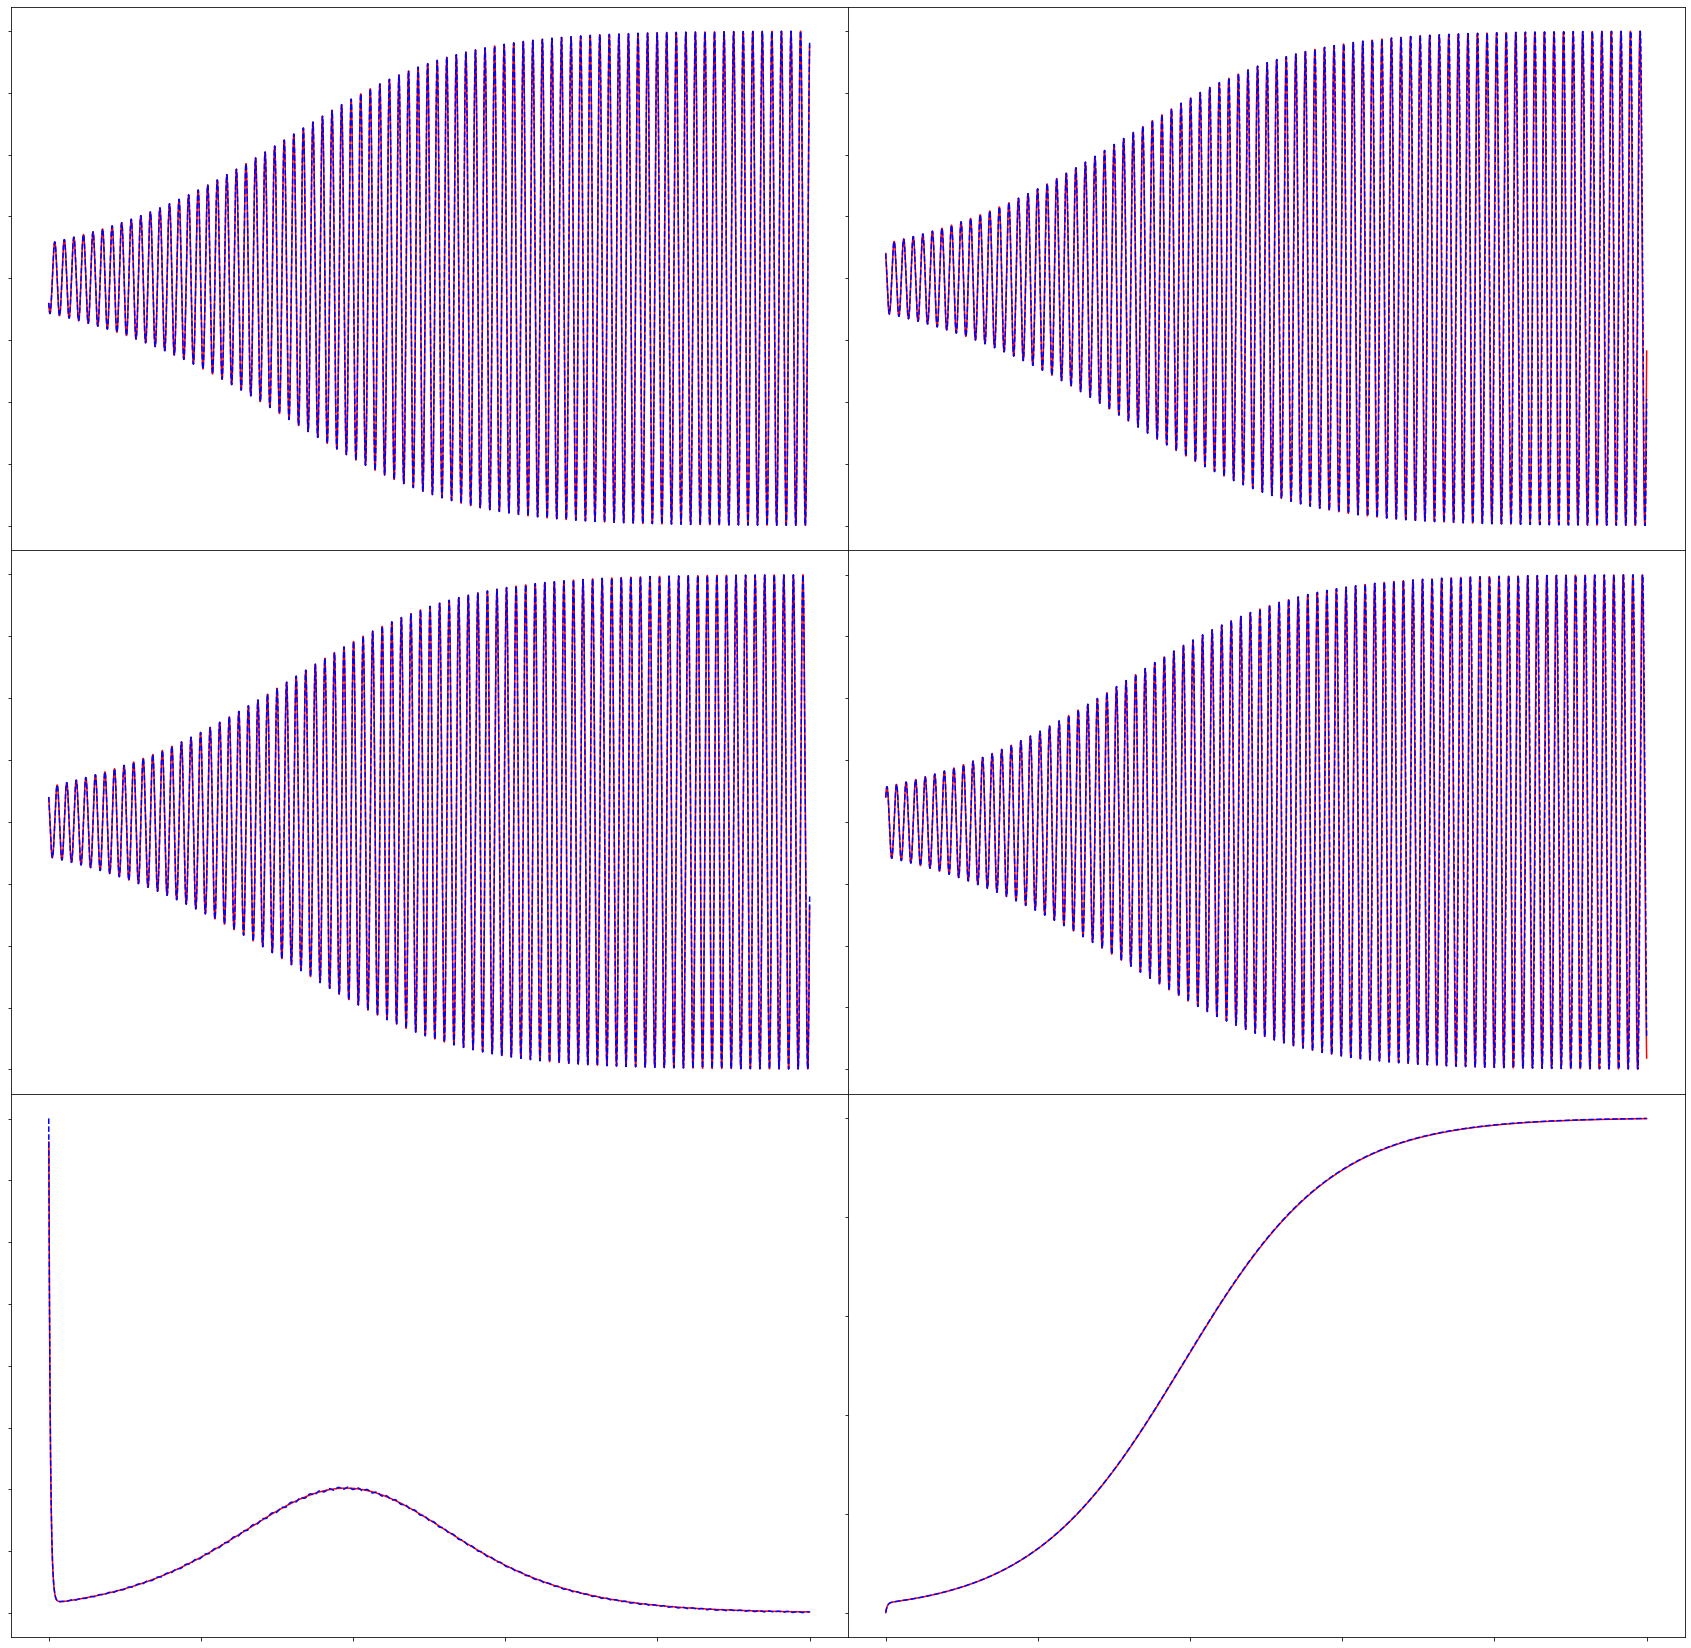

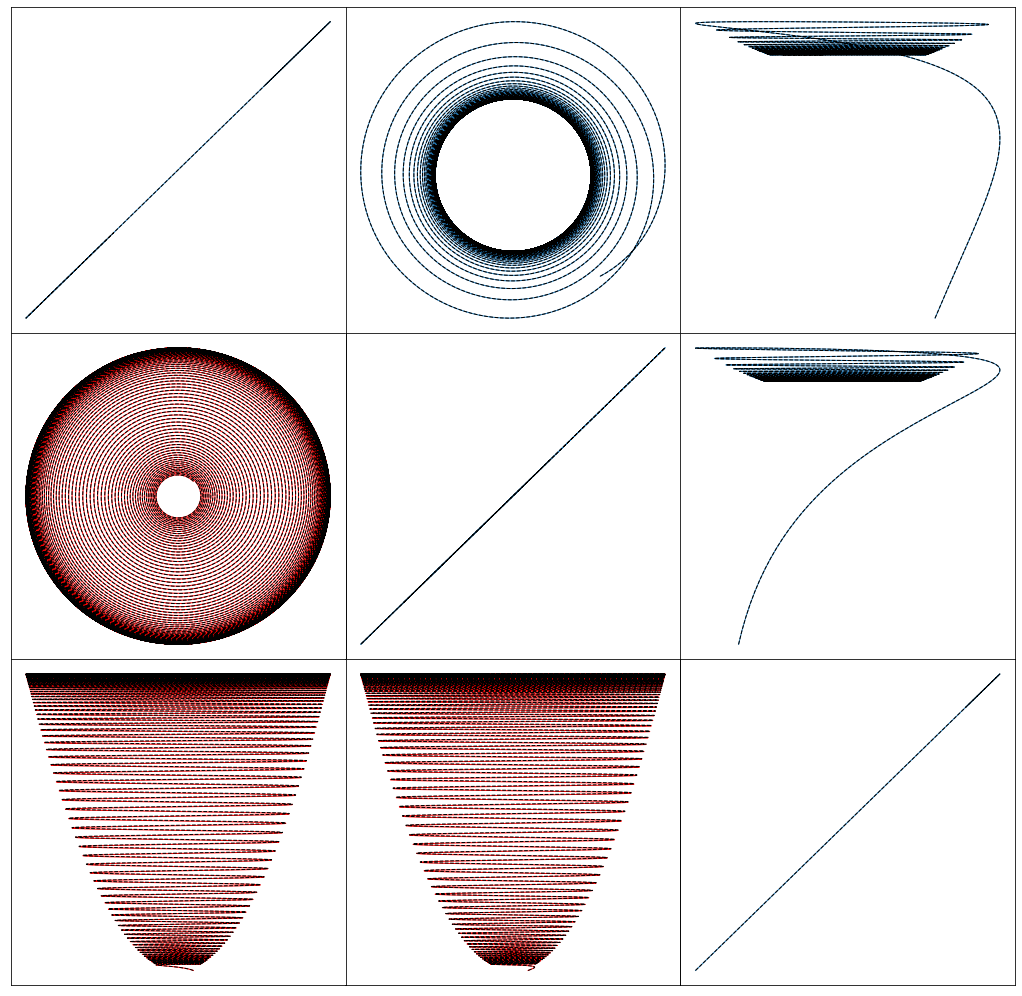

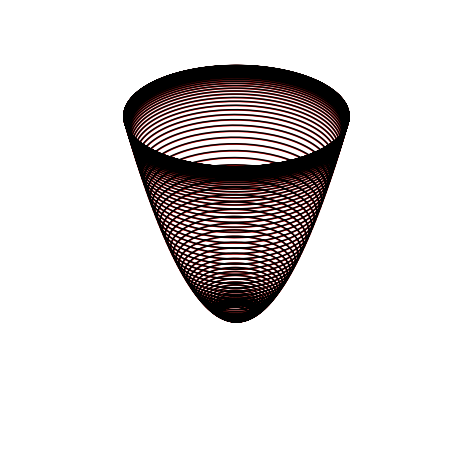

In [4]:
r = 3
mu = 1e-2
dt = 0.05
T = 500
t = np.arange(0, T + dt, dt)

x0 = np.random.rand(3) - 0.5
x_train = integrate.odeint(meanfield_deriv, x0, t, (mu,))
x0 = [mu, mu, 0]  # (np.random.rand(3) - 0.5)
x_test = integrate.odeint(meanfield_deriv, x0, t, (mu,))

# run trapping SINDy
threshold = 0.0
eta = 1e5
alpha_m = 1e-2 * eta
alpha_A = 1.0 * eta
relax_optim = False
if relax_optim:
    max_iter = 500
else:
    max_iter = 20

PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           mtol=1e-10, PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-20, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'meanfield')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'meanfield')
make_3d_plots(x_test, x_test_pred, 'meanfield')
#make_progress_plots(r, sindy_opt)

# Atmospheric oscillator model
Here we briefly look at a more complicated Lorenz-like system of coupled oscillators that is motivated from atmospheric dynamics. The model is
$$
\begin{align}
\label{eq:oscillator}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} = \begin{bmatrix}
    \mu_1 & 0 & 0 \\
    0 & \mu_2 & \omega \\
    0 & -\omega & \mu_2 
    \end{bmatrix}\begin{bmatrix} 
    x \\ 
    y \\
    z 
    \end{bmatrix}
    +
    \begin{bmatrix}
    \sigma xy \\
    \kappa yz + \beta z^2 - \sigma x^2 \\
    - \kappa y^2 - \beta yz
    \end{bmatrix}.
\end{align}
$$
For comparison, we assume the parameter choices in Tuwankotta et al. (2006), $\mu_1 = 0.05$, $\mu_2 = -0.01$, $\omega = 3$, $\sigma = 1.1$, $\kappa = -2$, and $\beta = -6$, for which a limit cycle is known to exist. Again, the algorithm shows straightforward success finding a model with a trapping region, for a range of hyperparameter values.

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.37197e-04  2.62216e-07  0.00000e+00
          50  1.37197e-04  7.78771e-09  0.00000e+00
         100  1.37197e-04  6.20701e-09  0.00000e+00
         150  1.37197e-04  5.64986e-09  0.00000e+00
         200  1.37197e-04  5.34378e-09  0.00000e+00
         250  1.37197e-04  5.16418e-09  0.00000e+00
         300  1.37197e-04  5.05759e-09  0.00000e+00
         350  1.37197e-04  4.99414e-09  0.00000e+00
         400  1.37197e-04  4.95632e-09  0.00000e+00
         450  1.37197e-04  4.93376e-09  0.00000e+00
x0' = 0.050 x0 + 1.100 x0x1
x1' = -0.010 x1 + 3.000 x2 + -2.000 x1x2 + -1.100 x0x0 + -4.999 x2x2
x2' = -3.000 x1 + -0.010 x2 + 4.999 x1x2 + 2.000 x1x1
optimal m:  [-0.08790575 -0.96466234  0.38580215]
As eigvals:  [-5.60437322 -1.01300362 -0.00800149]
d =  [-0.0510599   0.01387749 -0.00394115]
Rm =  0.002004836262136624


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


(501,) (501,)


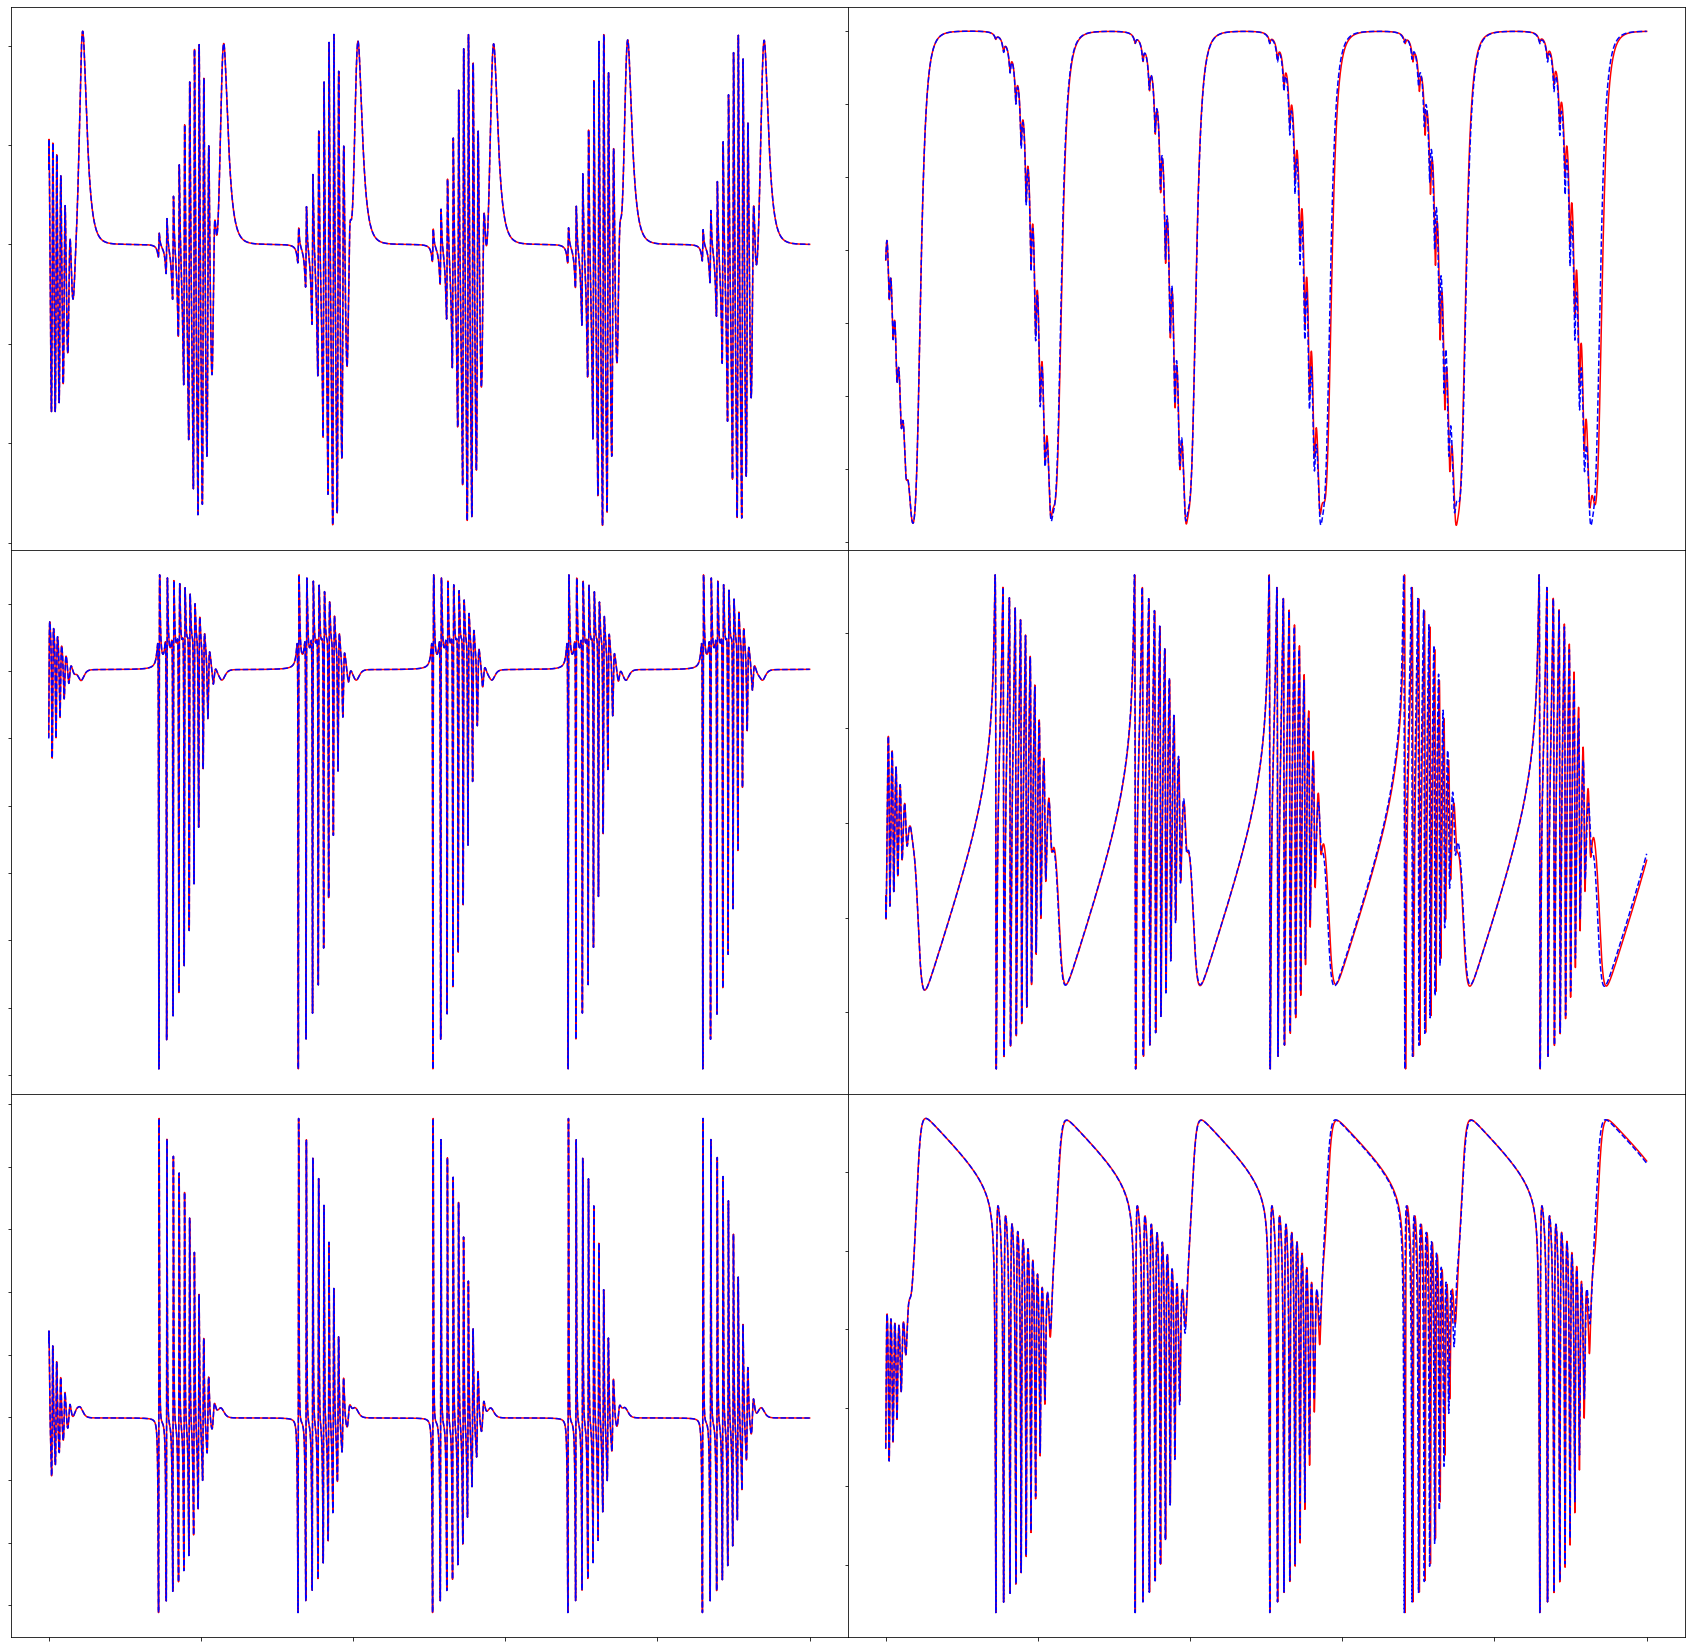

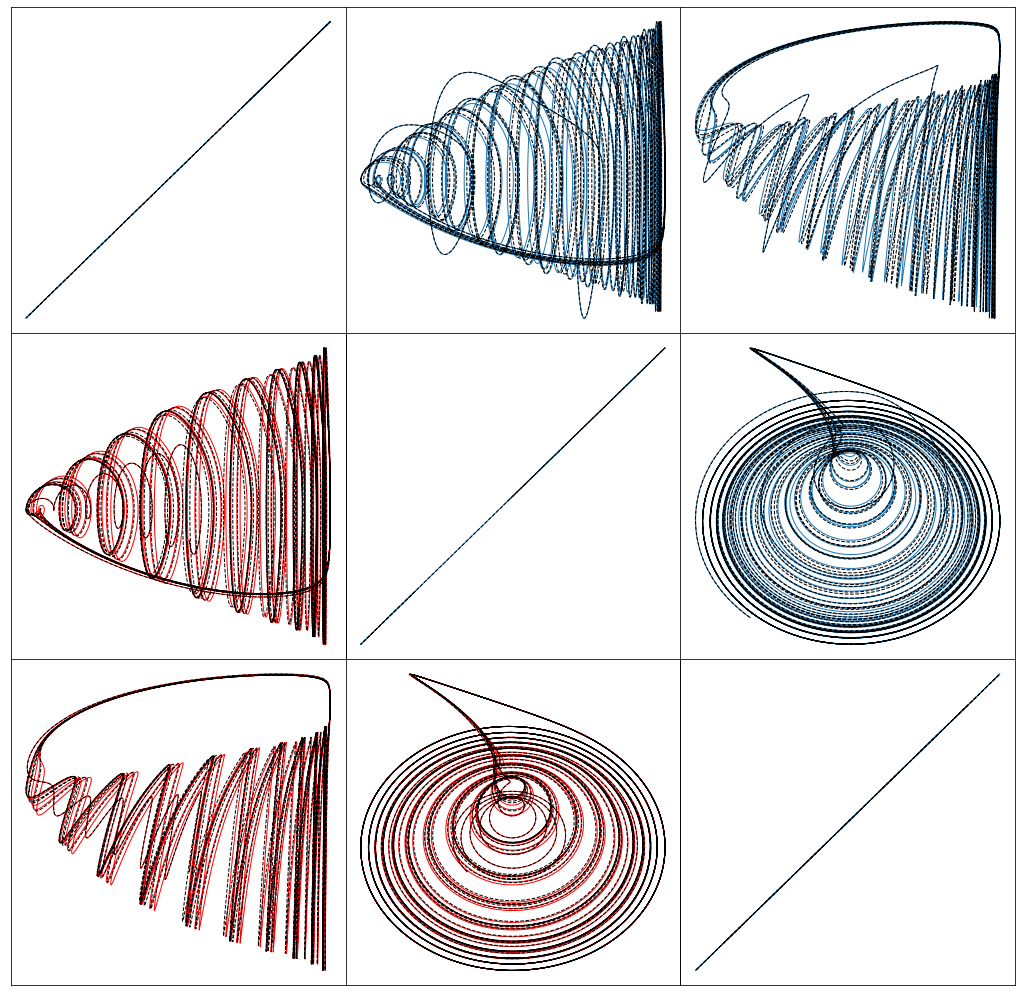

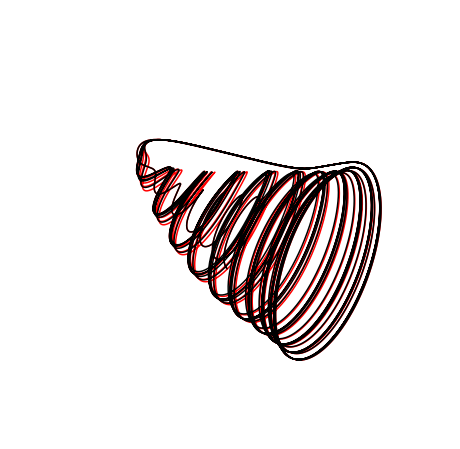

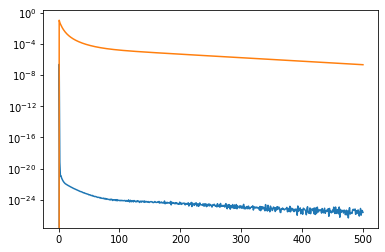

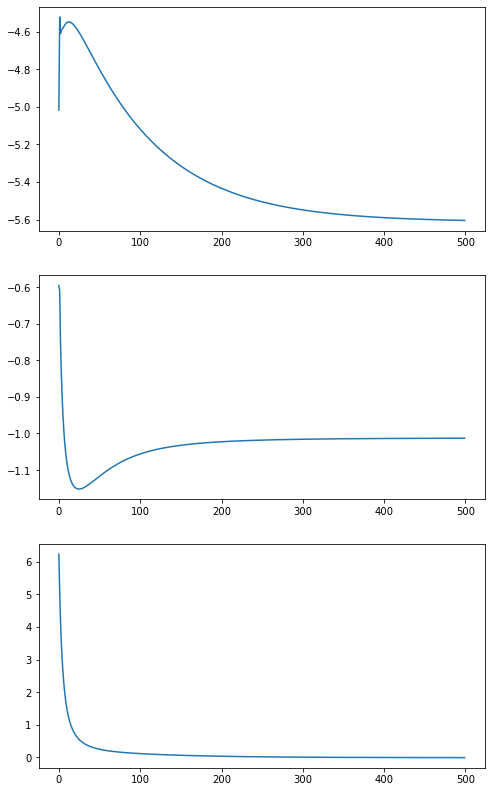

In [5]:
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps*k1
mu2 = -eps*k2
alpha = -2.0
omega = 3.0
dt = 0.005
T = 500
t = np.arange(0, T + dt, dt)

x0 = np.random.rand(3) - 0.5
x_train = integrate.odeint(oscillator_deriv, x0, t, (mu1, mu2, omega, alpha, beta, sigma))
x0 = np.random.rand(3) - 0.5
x_test = integrate.odeint(oscillator_deriv, x0, t, (mu1, mu2, omega, alpha, beta, sigma))

# run trapping SINDy
eta = 1.0e8
alpha_m = 1.0e-2 * eta
alpha_A = 1.0 * eta
threshold = 0.0
relax_optim = True
if relax_optim:
    max_iter = 500
else:
    max_iter = 20

PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, 
                           accel=False, mtol=1e-10,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-20,
                           gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'oscillator')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'oscillator')
make_3d_plots(x_test, x_test_pred, 'oscillator')
make_progress_plots(r, sindy_opt)

# Lorenz model
The Lorenz system originates from a simple fluid model of atmospheric dynamics from Lorenz et al. (1963).
This system is likely the most famous example of chaotic, nonlinear behavior despite the somewhat innocuous system of equations,
$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$
For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),
$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$
so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability. 

 Iteration | Data Error | Stability Error |   L1 Error
           0  8.52865e+04  1.25410e+05  0.00000e+00
       10000  1.17908e+03  3.14070e-01  0.00000e+00
       20000  1.17423e+03  3.08235e-01  0.00000e+00
       30000  1.17415e+03  3.08146e-01  0.00000e+00
       40000  1.17415e+03  3.08145e-01  0.00000e+00
       50000  1.17415e+03  3.08145e-01  0.00000e+00
       60000  1.17415e+03  3.08145e-01  0.00000e+00
       70000  1.17415e+03  3.08145e-01  0.00000e+00
       80000  1.17415e+03  3.08145e-01  0.00000e+00
       90000  1.17415e+03  3.08145e-01  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 100000 iterations.
  ConvergenceWarning,


x0' = -10.045 x0 + 10.035 x1 + 0.010 x2 + 0.002 x0x2 + -0.002 x1x2
x1' = 27.111 x0 + -0.503 x1 + 0.026 x2 + -0.976 x0x2 + -0.012 x1x2 + -0.001 x2x2
x2' = -0.057 x0 + 0.018 x1 + -2.625 x2 + 0.978 x0x1 + 0.001 x1x2 + -0.002 x0x0 + 0.012 x1x1
optimal m:  [ 2.72744126  0.15317375 38.22796417]
As eigvals:  [-9.96127791 -2.62427838 -0.97517481]
d =  [ -25.31473025  102.68900448 -100.64055456]
Rm =  45.67937433246058
(100001,) (100001,)


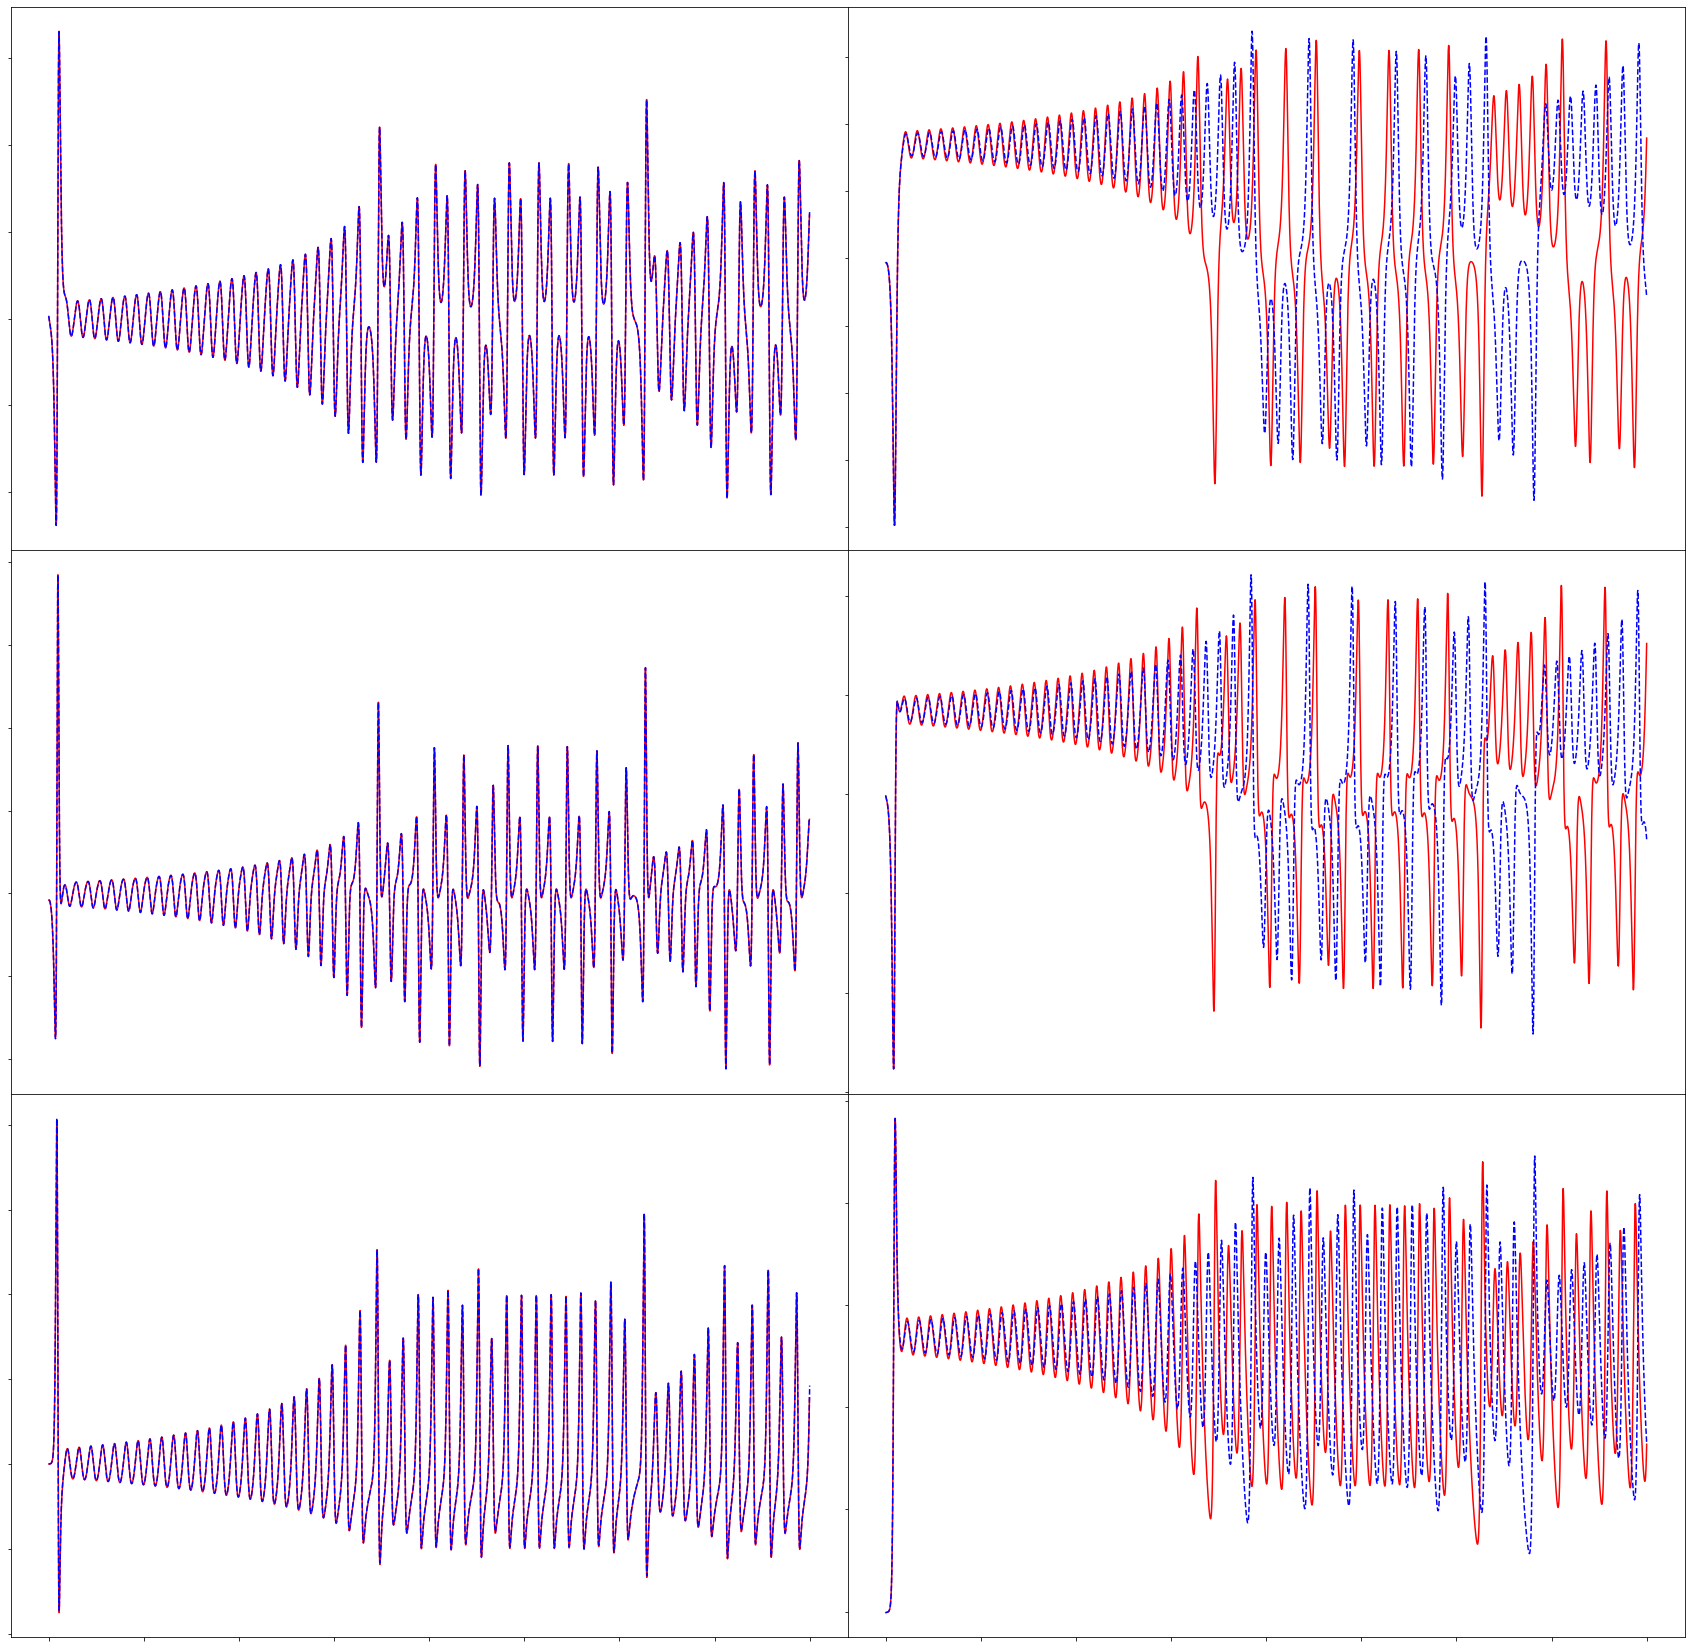

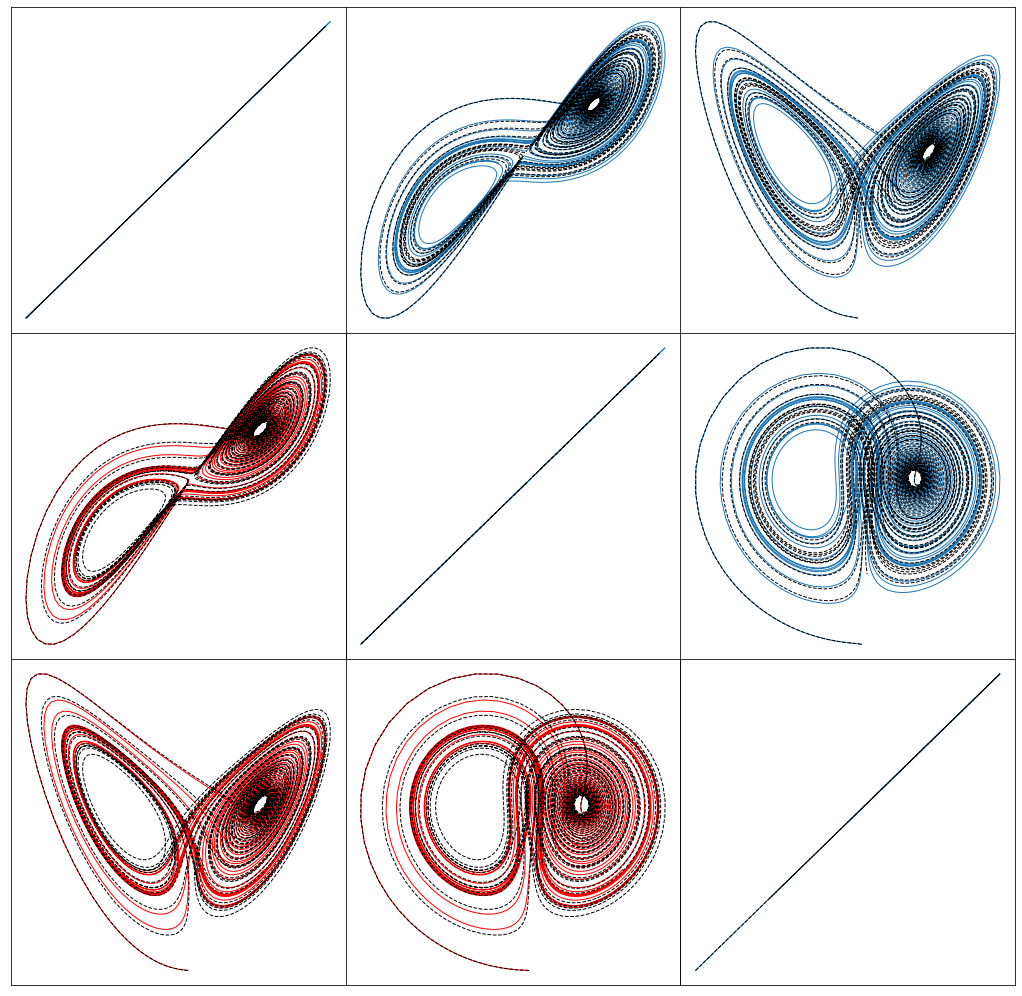

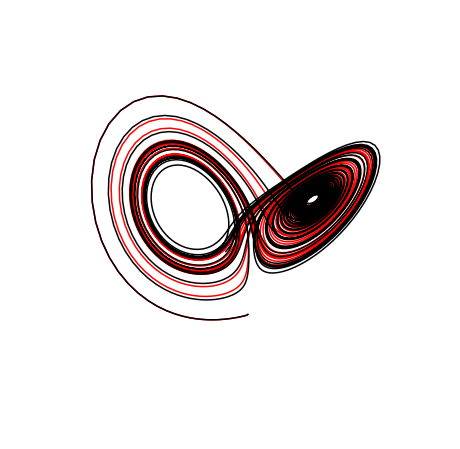

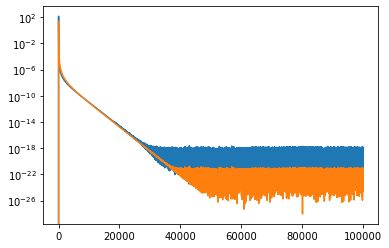

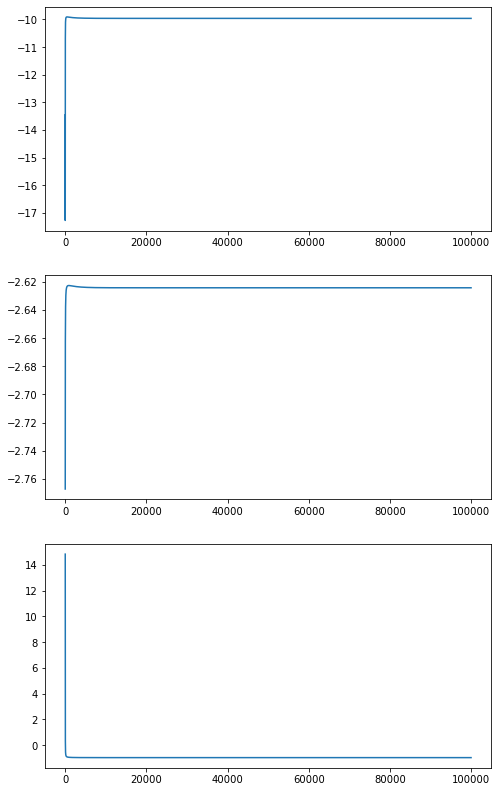

In [6]:
r = 3
sigma = 10.0
beta = 8.0/3.0
rho = 28.0

dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)

x0 = np.random.rand(3) - 0.5
x_train = integrate.odeint(lorenz_deriv, x0, t, (sigma, beta, rho))
x0 = np.random.rand(3) - 0.5
x_test = integrate.odeint(lorenz_deriv, x0, t, (sigma, beta, rho))

# run trapping SINDy
if relax_optim:
    max_iter = 100000
    eta = 1.0e-3
else:
    max_iter = 20
    eta = 1.0e-4
alpha_m = 0.5 * eta
alpha_A = 1.0 * eta
threshold = 0.0
relax_optim = True
    
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, 
                           accel=False, mtol=1e-10,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-20,
                           gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'lorenz')
make_3d_plots(x_test, x_test_pred, 'lorenz')
make_progress_plots(r, sindy_opt)

# Visualizing the trapping region for Lorenz
Below, we plot the SINDy-identified trapping region for the Lorenz system. It correctly encloses the Lorenz attractor, and the red ellipsoid of positive energy growth. We can see that trajectories starting outside of this region monotonically fall into this region and remain forever. 

optimal m:  [ 2.72744126  0.15317375 38.22796417]
As eigvals:  [-9.96127791 -2.62427838 -0.97517481]
8.640987597877146 45.723808531952656 28.0


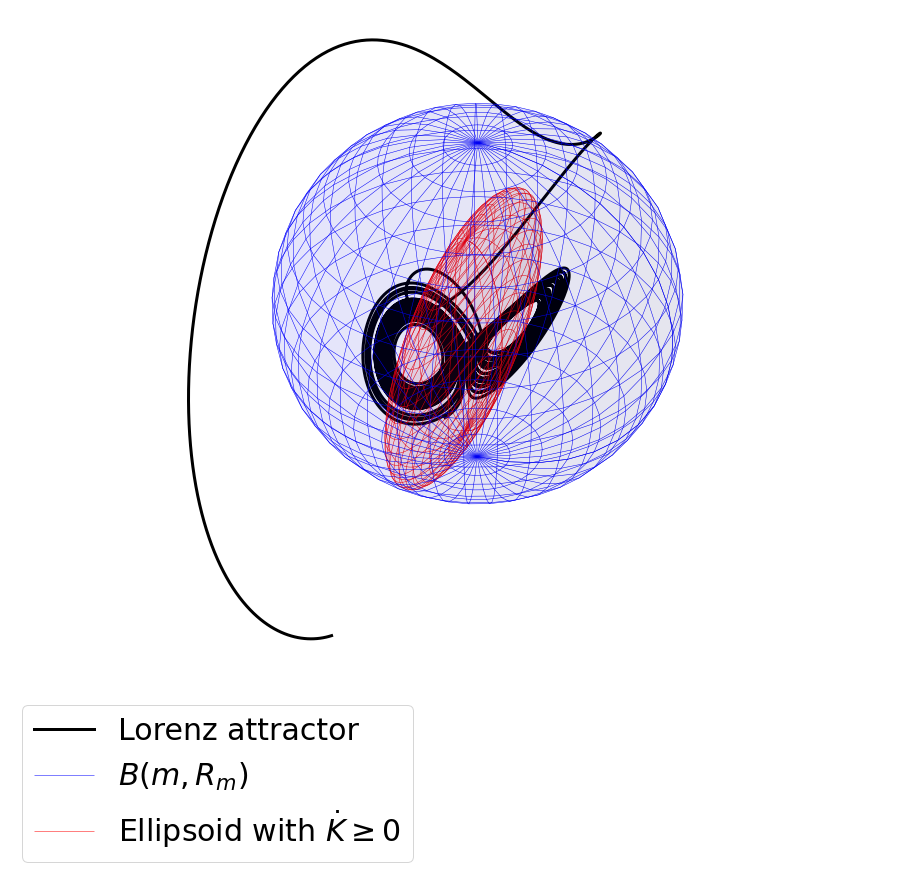

In [7]:
# Need to compute A^S from the optimal m obtained from SINDy algorithm
Nr = int((r ** 2 + 3 * r) / 2.0)
opt_m = sindy_opt.m_history_[-1]
PL_tensor = sindy_opt.PL
PQ_tensor = sindy_opt.PQ
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i + 1, r):
        mPQ[i, j, :, int((i + 1) / 2.0 * (2 * r - i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eigh(As)
print('optimal m: ', opt_m)
print('As eigvals: ', np.sort(eigvals))

# Extract smallest and largest eigenvalues, and compute radius of the trapping region
smallest_eigval = np.sort(eigvals)[-1]
largest_eigval = np.sort(eigvals)[0]
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([0], [0])), opt_m)
Rm = np.sqrt(smallest_eigval / largest_eigval) * np.linalg.norm(d)

# Make 3D plot illustrating the trapping region
alpha = 1.0
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(16, 16))
dt = 0.001
T = 40
t = np.arange(0, T + dt, dt)
x0 = (np.random.rand(r) - 0.5) * 100
x_test_pred = model.simulate(x0, t, integrator_kws=integrator_keywords)
# Plot Lorenz trajectory
plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k', 
         label='Lorenz attractor', alpha=alpha, linewidth=3)

# draw sphere
u, v = np.mgrid[0 : 2 * np.pi : 40j, 0 : np.pi : 20j]
x = Rm * np.cos(u) * np.sin(v) + opt_m[0]
y = Rm * np.sin(u) * np.sin(v) + opt_m[1]
z = Rm * np.cos(v) + opt_m[2]
ax.plot_wireframe(x, y, z, color="b",label=r'$B(m, R_m)$', alpha=alpha, linewidth=0.5)
ax.plot_surface(x, y, z, color="b", alpha=0.05)

# define ellipsoid
# Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
coefs = (1 / (beta * rho), 1 / (beta * rho**2), 1 / (rho ** 2))  
# Radii corresponding to the coefficients:
rx, ry, rz = 1.0 / np.sqrt(coefs)

# Set of all spherical angles:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v)) + rho

# Plot ellipsoid
ax.plot_wireframe(x, y, z, rstride=4, cstride=4, color='r', 
                  label=r'Ellipsoid with $\dot{K} \geq 0$', alpha=alpha, linewidth=0.5)
ax.plot_surface(x, y, z, rstride=4, cstride=4, color='r', alpha=0.05)

# Adjustment of the axes, so that they all have the same span:
max_radius = max(rx, ry, rz) * 1.2
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))

plt.legend(fontsize=30, loc='lower left')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_axis_off()
ax.view_init(elev=40., azim=-70)

plt.savefig('TrappingRegion.pdf')

# Illustration of the algorithm improvements
On noisy data, unconstrained or constrained SINDy algorithms typically take a bad first guess that may persist. Here, we illustrate that the trapping SINDy algorithm can take a bad first guess and then iteratively improve, so that the end result is correct identification of the Lorenz attractor dynamics.

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 1 iterations.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00
          15  1.52640e+09  1.56927e+06  0.00000e+00
          30  1.52655e+09  2.32490e+05  0.00000e+00
          45  1.52661e+09  9.95363e+04  0.00000e+00
          60  1.52665e+09  7.02491e+04  0.00000e+00
          75  1.52667e+09  6.11682e+04  0.00000e+00
          90  1.52668e+09  5.79056e+04  0.00000e+00
         105  1.52669e+09  5.66479e+04  0.00000e+00
         120  1.52670e+09  5.61412e+04  0.00000e+00
         135  1.52670e+09  5.59291e+04  0.00000e+00
         150  1.52670e+09  5.58365e+04  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 152 iterations.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00
          15  1.52640e+09  1.56927e+06  0.00000e+00
          30  1.52655e+09  2.32490e+05  0.00000e+00
          45  1.52661e+09  9.95363e+04  0.00000e+00
          60  1.52665e+09  7.02491e+04  0.00000e+00
          75  1.52667e+09  6.11682e+04  0.00000e+00
          90  1.52668e+09  5.79056e+04  0.00000e+00
         105  1.52669e+09  5.66479e+04  0.00000e+00
         120  1.52670e+09  5.61412e+04  0.00000e+00
         135  1.52670e+09  5.59291e+04  0.00000e+00
         150  1.52670e+09  5.58365e+04  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 153 iterations.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00
          15  1.52640e+09  1.56927e+06  0.00000e+00
          30  1.52655e+09  2.32490e+05  0.00000e+00
          45  1.52661e+09  9.95363e+04  0.00000e+00
          60  1.52665e+09  7.02491e+04  0.00000e+00
          75  1.52667e+09  6.11682e+04  0.00000e+00
          90  1.52668e+09  5.79056e+04  0.00000e+00
         105  1.52669e+09  5.66479e+04  0.00000e+00
         120  1.52670e+09  5.61412e+04  0.00000e+00
         135  1.52670e+09  5.59291e+04  0.00000e+00
         150  1.52670e+09  5.58365e+04  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 154 iterations.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00
          15  1.52640e+09  1.56927e+06  0.00000e+00
          30  1.52655e+09  2.32490e+05  0.00000e+00
          45  1.52661e+09  9.95363e+04  0.00000e+00
          60  1.52665e+09  7.02491e+04  0.00000e+00
          75  1.52667e+09  6.11682e+04  0.00000e+00
          90  1.52668e+09  5.79056e+04  0.00000e+00
         105  1.52669e+09  5.66479e+04  0.00000e+00
         120  1.52670e+09  5.61412e+04  0.00000e+00
         135  1.52670e+09  5.59291e+04  0.00000e+00
         150  1.52670e+09  5.58365e+04  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 155 iterations.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00
          15  1.52640e+09  1.56927e+06  0.00000e+00
          30  1.52655e+09  2.32490e+05  0.00000e+00
          45  1.52661e+09  9.95363e+04  0.00000e+00
          60  1.52665e+09  7.02491e+04  0.00000e+00
          75  1.52667e+09  6.11682e+04  0.00000e+00
          90  1.52668e+09  5.79056e+04  0.00000e+00
         105  1.52669e+09  5.66479e+04  0.00000e+00
         120  1.52670e+09  5.61412e+04  0.00000e+00
         135  1.52670e+09  5.59291e+04  0.00000e+00
         150  1.52670e+09  5.58365e+04  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 156 iterations.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00
          15  1.52640e+09  1.56927e+06  0.00000e+00
          30  1.52655e+09  2.32490e+05  0.00000e+00
          45  1.52661e+09  9.95363e+04  0.00000e+00
          60  1.52665e+09  7.02491e+04  0.00000e+00
          75  1.52667e+09  6.11682e+04  0.00000e+00
          90  1.52668e+09  5.79056e+04  0.00000e+00
         105  1.52669e+09  5.66479e+04  0.00000e+00
         120  1.52670e+09  5.61412e+04  0.00000e+00
         135  1.52670e+09  5.59291e+04  0.00000e+00
         150  1.52670e+09  5.58365e+04  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 157 iterations.
  ConvergenceWarning,


 Iteration | Data Error | Stability Error |   L1 Error
           0  1.52695e+09  5.86486e+06  0.00000e+00
         500  1.52671e+09  5.57511e+04  0.00000e+00
        1000  1.52671e+09  5.57511e+04  0.00000e+00
        1500  1.52671e+09  5.57511e+04  0.00000e+00
        2000  1.52671e+09  5.57511e+04  0.00000e+00
        2500  1.52671e+09  5.57511e+04  0.00000e+00
        3000  1.52671e+09  5.57511e+04  0.00000e+00
        3500  1.52671e+09  5.57511e+04  0.00000e+00
        4000  1.52671e+09  5.57511e+04  0.00000e+00
        4500  1.52671e+09  5.57511e+04  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 5000 iterations.
  ConvergenceWarning,


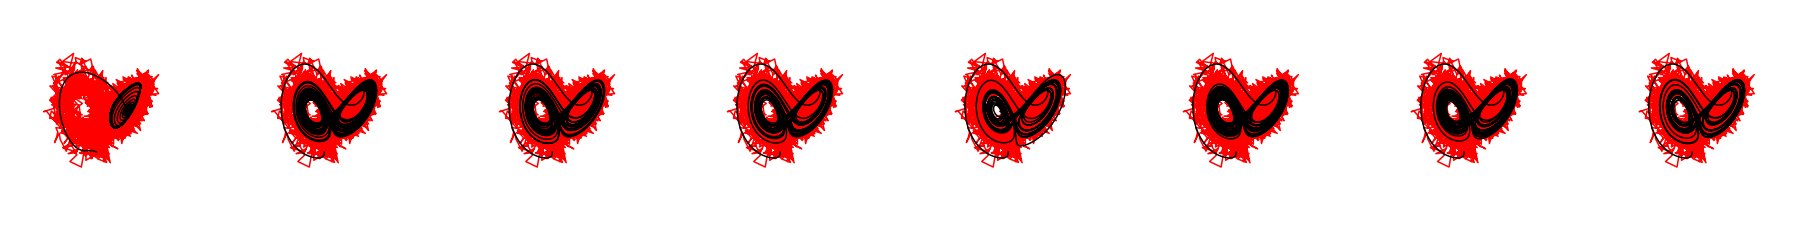

In [8]:
# Rerun with some noise to illustrate the trapping SINDy process
r = 3
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0

dt = 0.005
T = 40
t = np.arange(0, T + dt, dt)

x0 = (np.random.rand(3) - 0.5)
x_train = integrate.odeint(lorenz_deriv, x0, t, (sigma, beta, rho), 
                           rtol=10 ** (-12), atol=10 ** (-12) * np.ones(r))

# run trapping SINDy
eta = 1.0e-5
alpha_m = 0.5 * eta
alpha_A = 1.0 * eta
threshold = 0.0
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
noise = np.random.normal(0.0, 2.5, x_train.shape)
x_train = x_train + noise
x_test = x_train

fig, ax = plt.subplots(1, 8, subplot_kw={'projection': '3d'}, figsize=(32, 4))

iters = [1, 152, 153, 154, 155, 156, 157, 5000]
for iter_ind in range(len(iters)):
    miter = iters[iter_ind]
    sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, 
                               accel=False, mtol=1e-10,
                               PL=PL_tensor, PQ=PQ_tensor, max_iter=miter, tol=1e-20,
                               gamma=-1,
                               constraint_lhs=constraint_matrix,
                               constraint_rhs=constraint_zeros,
                               constraint_order="feature")

    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
        differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    )
    model.fit(x_train, t=t)
    Xi = model.coefficients().T
    xdot_test = model.differentiate(x_test, t=t)
    xdot_test_pred = model.predict(x_test)
    x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
    ax[iter_ind].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'r')
    ax[iter_ind].plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k')
    ax[iter_ind].set_xticklabels([])
    ax[iter_ind].set_yticklabels([])
    ax[iter_ind].set_zticklabels([])
    ax[iter_ind].set_axis_off()

plt.savefig('lorenz_trappingSINDy_evo.pdf')

# Comparison between unconstrained, constrained, and trapping algorithms on noisy Lorenz data
Below, we test the three SINDy variants on noisy Lorenz data for a number of noise instantiations and initial conditions. We find the trapping algorithm can significantly improve the robustness of the models. 
Note that this code takes a LONG time if lambda != 0 because CVXPY is slow and the initial guess for m0 may start fairly far away from the optimal value.

In [ ]:
if True:
    x0 = [1, -1, 20]
    thresholds = [0.0, 0.01, 0.1]
    variances = np.ones(4) * 4.0
    x_orig = integrate.odeint(lorenz_deriv, x0, t, (sigma, beta, rho))
    x0_pred = (np.random.rand(2, 2, 3) - 0.5) * 20
    for threshold in thresholds:
        fig1,ax1 = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(8, 8))
        fig2,ax2 = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(8, 8))
        fig3,ax3 = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(8, 8))
        for ii in range(2):
            for jj in range(2):
                noise = np.random.normal(0.0, variances[ii * 2 + jj], x_train.shape)
                x_train = x_orig + noise
                x_test = integrate.odeint(lorenz_deriv, x0_pred[ii, jj], t, (sigma, beta, rho))
                # unconstrained SINDy
                sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=1.0, 
                                              max_iter=2000, tol=1e-10, thresholder="l1")

                model = ps.SINDy(
                    optimizer=sindy_opt,
                    feature_library=sindy_library,
                    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
                )
                model.fit(x_train, t=t)
                ax1[ii, jj].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], linewidth=2)
                x_test_pred = model.simulate(x0_pred[ii, jj], t, integrator_kws=integrator_keywords)
                if not np.any(np.abs(x_test_pred) > 100):
                    ax1[ii, jj].plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'r--', linewidth=2)

                # constrained SINDy
                sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=1.0, max_iter=2000, tol=1e-10,
                                              thresholder="l1",
                                              constraint_lhs=constraint_matrix,
                                              constraint_rhs=constraint_zeros,
                                              constraint_order="feature")
                model = ps.SINDy(
                    optimizer=sindy_opt,
                    feature_library=sindy_library,
                    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
                )
                model.fit(x_train, t=t)
                ax2[ii, jj].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], linewidth=2)
                x_test_pred = model.simulate(x0_pred[ii, jj], t, integrator_kws=integrator_keywords)
                if not np.any(np.abs(x_test_pred) > 100):
                    ax2[ii, jj].plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'm--', linewidth=2)

                eta = 1.0e-4
                alpha_m = 5e-2 * eta
                alpha_A = 1.0 * eta
                if threshold == 0.0:
                    max_iter = 40000
                else:
                    alpha_m = 5e-1 * eta
                    max_iter = 100  # 1200

                # trapping SINDy -- initial guess for m because otherwise this takes a long time
                sindy_opt = ps.trappingSR3(threshold=threshold, alpha_m=alpha_m, alpha_A=alpha_A, eta=eta, 
                                           mtol=1e-8, accel=False,
                                           PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-15,
                                           m0=[1, 0, 31], gamma=-0.1,
                                           constraint_lhs=constraint_matrix,
                                           constraint_rhs=constraint_zeros,
                                           constraint_order="feature")
                model = ps.SINDy(
                    optimizer=sindy_opt,
                    feature_library=sindy_library,
                    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
                )
                model.fit(x_train, t=t)
                Xi = model.coefficients().T
                check_stability(r, Xi, sindy_opt)
                ax3[ii, jj].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], linewidth=2)
                x_test_pred = model.simulate(x0_pred[ii, jj], t, integrator_kws=integrator_keywords)
                ax3[ii, jj].plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k--', linewidth=2)
                ax1[ii, jj].set_xticklabels([])
                ax1[ii, jj].set_yticklabels([])
                ax1[ii, jj].set_zticklabels([])     
                ax1[ii, jj].dist = 8
                ax1[ii, jj].set_axis_off()
                ax2[ii, jj].set_xticklabels([])
                ax2[ii, jj].set_yticklabels([])
                ax2[ii, jj].set_zticklabels([])     
                ax2[ii, jj].dist = 8
                ax2[ii, jj].set_axis_off()
                ax3[ii, jj].set_xticklabels([])
                ax3[ii, jj].set_yticklabels([])
                ax3[ii, jj].set_zticklabels([])     
                ax3[ii, jj].dist = 8
                ax3[ii, jj].set_axis_off()

        fig1.savefig('lorenz_unconstrained' + str(threshold) + '.pdf')
        fig2.savefig('lorenz_constrained' + str(threshold) + '.pdf')
        fig3.savefig('lorenz_trapping' + str(threshold) + '.pdf')

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


 Iteration | Data Error | Stability Error |   L1 Error
           0  3.90096e+09  4.49411e+03  0.00000e+00
        4000  3.90099e+09  4.32951e+03  0.00000e+00
        8000  3.90099e+09  4.33352e+03  0.00000e+00
       12000  3.90099e+09  4.33447e+03  0.00000e+00
       16000  3.90099e+09  4.33456e+03  0.00000e+00
       20000  3.90099e+09  4.33456e+03  0.00000e+00
       24000  3.90099e+09  4.33456e+03  0.00000e+00
       28000  3.90099e+09  4.33456e+03  0.00000e+00
       32000  3.90099e+09  4.33456e+03  0.00000e+00
       36000  3.90099e+09  4.33456e+03  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 40000 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in sqrt


optimal m:  [ 0.57631681  0.0425488  33.57198216]
As eigvals:  [-3.87483691 -2.03805604  0.83108134]
d =  [ -9.68374391  -1.04127756 -71.41728675]
Rm =  nan


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


 Iteration | Data Error | Stability Error |   L1 Error
           0  3.92168e+09  6.66657e+03  0.00000e+00
        4000  3.92221e+09  4.56967e+03  0.00000e+00
        8000  3.92238e+09  4.09911e+03  0.00000e+00
       12000  3.92247e+09  3.91780e+03  0.00000e+00
       16000  3.92252e+09  3.82883e+03  0.00000e+00
       20000  3.92254e+09  3.78062e+03  0.00000e+00
       24000  3.92256e+09  3.75312e+03  0.00000e+00
       28000  3.92257e+09  3.73697e+03  0.00000e+00
       32000  3.92257e+09  3.72733e+03  0.00000e+00
       36000  3.92258e+09  3.72152e+03  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 40000 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in sqrt


optimal m:  [ 5.89258965  0.61042713 30.74987449]
As eigvals:  [-3.42660903 -1.99056699  0.76232139]
d =  [ -0.68516931 129.08561997 -67.63588145]
Rm =  nan
 Iteration | Data Error | Stability Error |   L1 Error
           0  3.82925e+09  1.61403e+03  0.00000e+00
        4000  3.82952e+09  4.01411e-02  0.00000e+00
        8000  3.82953e+09  8.39365e-06  0.00000e+00
       12000  3.82953e+09  1.79451e-09  0.00000e+00
       16000  3.82953e+09  3.83702e-13  0.00000e+00
       20000  3.82953e+09  8.18199e-17  0.00000e+00
       24000  3.82953e+09  8.83401e-21  0.00000e+00
       28000  3.82953e+09  1.64851e-26  0.00000e+00
       32000  3.82953e+09  2.03360e-27  0.00000e+00
       36000  3.82953e+09  7.54880e-27  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 40000 iterations.
  ConvergenceWarning,


optimal m:  [ 2.2844688   0.10876596 33.62958235]
As eigvals:  [-4.39610994 -2.27540683 -0.1       ]
d =  [-21.0613366   45.62835103 -75.56918127]
Rm =  13.68768159496917
 Iteration | Data Error | Stability Error |   L1 Error
           0  3.91628e+09  2.51540e+03  0.00000e+00
        4000  3.91656e+09  2.32355e+02  0.00000e+00
        8000  3.91673e+09  2.52622e+02  0.00000e+00
       12000  3.91685e+09  2.55421e+02  0.00000e+00
       16000  3.91693e+09  2.41901e+02  0.00000e+00
       20000  3.91698e+09  2.29030e+02  0.00000e+00
       24000  3.91701e+09  2.20106e+02  0.00000e+00
       28000  3.91702e+09  2.14341e+02  0.00000e+00
       32000  3.91704e+09  2.10642e+02  0.00000e+00
       36000  3.91705e+09  2.08243e+02  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 40000 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in sqrt


optimal m:  [ 3.57237723  1.14684861 34.72725343]
As eigvals:  [-4.14567422 -1.85904711  0.10330535]
d =  [ -2.33284253  67.68063718 -68.52687997]
Rm =  nan
 Iteration | Data Error | Stability Error |   L1 Error
           0  3.86855e+09  9.86126e+03  2.62129e-01
           1  3.86858e+09  1.01332e+04  2.59841e-01
           2  3.86858e+09  1.01075e+04  2.59906e-01
           3  3.86858e+09  1.01107e+04  2.59909e-01
           4  3.86858e+09  1.01122e+04  2.59917e-01
           5  3.86858e+09  1.01138e+04  2.59925e-01
           6  3.86858e+09  1.01154e+04  2.59933e-01
           7  3.86858e+09  1.01171e+04  2.59941e-01
           8  3.86858e+09  1.01188e+04  2.59948e-01
           9  3.86858e+09  1.01205e+04  2.59956e-01
          10  3.86858e+09  1.01222e+04  2.59963e-01
          11  3.86858e+09  1.01239e+04  2.59970e-01
          12  3.86858e+09  1.01256e+04  2.59977e-01
          13  3.86858e+09  1.01274e+04  2.59984e-01
          14  3.86858e+09  1.01291e+04  2.59991e-01
        

/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:526: ConvergenceWarning: trappingSR3._reduce did not converge after 100 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in sqrt


 Iteration | Data Error | Stability Error |   L1 Error
           0  3.79831e+09  9.38696e+03  2.76045e-01
           1  3.79835e+09  1.04119e+04  2.73507e-01
           2  3.79835e+09  1.01776e+04  2.73431e-01
           3  3.79835e+09  1.00155e+04  2.73381e-01
           4  3.79835e+09  9.85823e+03  2.73328e-01
           5  3.79836e+09  9.70822e+03  2.73271e-01
           6  3.79836e+09  9.56502e+03  2.73210e-01
           7  3.79836e+09  9.42828e+03  2.73146e-01
           8  3.79836e+09  9.29767e+03  2.73078e-01
           9  3.79836e+09  9.17287e+03  2.73007e-01
          10  3.79837e+09  9.05360e+03  2.72933e-01
          11  3.79837e+09  8.93958e+03  2.72856e-01
          12  3.79837e+09  8.83059e+03  2.72774e-01
          13  3.79837e+09  8.72627e+03  2.72692e-01
          14  3.79838e+09  8.62647e+03  2.72607e-01
          15  3.79838e+09  8.53096e+03  2.72519e-01
          16  3.79838e+09  8.43953e+03  2.72429e-01
          17  3.79838e+09  8.35198e+03  2.72337e-01
         

# MHD model
Magnetohydrodynamics exhibit quadratic nonlinearities that are often energy-preserving with typical boundary conditions. 
We consider a simple model of the nonlinearity in 2D incompressible MHD, which can be obtained from Fourier-Galerkin projection onto a single triad of wave vectors. For the wave vectors $(1,1)$, $(2,-1)$, and $(3,0)$ and no background magnetic field, the Carbone and Veltri (1992) system is 
$$
\begin{align}
\label{eq:simpleMHD_model}
    \begin{bmatrix}
    \dot{V}_1 \\
    \dot{V}_2 \\
    \dot{V}_3 \\ 
    \dot{B}_1 \\
    \dot{B}_2 \\
    \dot{B}_3 \\
    \end{bmatrix} = \begin{bmatrix}
    -2 \nu & 0 & 0 & 0 & 0 & 0 \\
    0 & -5 \nu & 0 & 0 & 0 & 0 \\
    0 & 0 & -9 \nu & 0 & 0 & 0 \\
    0 & 0 & 0 & -2 \mu & 0 & 0 \\
    0 & 0 & 0 & 0 & -5 \mu & 0 \\
    0 & 0 & 0 & 0 & 0 & -9 \mu \\
    \end{bmatrix}\begin{bmatrix}
    V_1 \\ 
    V_2 \\ 
    V_3 \\ 
    B_1 \\ 
    B_2 \\ 
    B_3 
    \end{bmatrix} + \begin{bmatrix}
    4(V_2V_3 - B_2B_3) \\ 
    -7(V_1V_3 - B_1B_3) \\ 
    3(V_1V_2 - B_1B_2) \\ 
    2(B_3V_2 - V_3B_2) \\ 
    5(V_3B_1 - B_3V_1) \\ 
    9(V_1B_2 - B_1V_2) \\ 
    \end{bmatrix},
\end{align}
$$
where $\nu \geq 0$ is the viscosity and $\mu \geq 0$ is the resistivity. Without external forcing, this system is trivially stable (it dissipates to zero), so we consider the inviscid limit $\nu = \mu = 0$. The system is then Hamiltonian and our algorithm correctly converges to $\mathbf{m} = 0$, $\mathbf{A}^S = 0$. The reason our algorithm converges to the correct behavior is because it is still minimizing $\dot{K}$; in this case trapping SINDy minimizes to $\dot{K} \approx 0$ and can make no further improvement.

In [ ]:
r = 6
nu = 0.0
mu = 0.0

dt = 0.005
T = 100
t = np.arange(0, T + dt, dt)

x0 = (np.random.rand(6) - 0.5)
x_train = integrate.odeint(mhd_deriv, x0, t)
x0 = (np.random.rand(6) - 0.5)
x_test = integrate.odeint(mhd_deriv, x0, t)

# run trapping SINDy
eta = 1.0e3
alpha_m = 5.0e-3 * eta
alpha_A = 1.0 * eta
threshold = 0.0
relax_optim = False
if relax_optim:
    max_iter = 1500
    eta = 1.0e3
else:
    max_iter = 10
    eta = 1.0e3
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, 
                           accel=False, mtol=1e-10,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-20,
                           gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'mhd')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'mhd')
make_3d_plots(x_test, x_test_pred, 'mhd')
make_progress_plots(r, sindy_opt)

# Forced Burger's Equation
The viscous Burgers' equation has long served as a simplified one-dimensional turbulence analogue (Burgers/Hopf 1948). The forced, viscous Burgers' equation on a periodic domain $x \in [0,2\pi)$ is:
$$
\begin{align}
\label{eq:burgers}
    \dot{u} &= -(U + u)\partial_x u + \nu \partial_{xx}^2u + g(x,t),
\end{align}
$$
where $\nu$ is viscosity and the constant $U$ models mean-flow advection. 
We project this system onto a Fourier basis and assume constant forcing acting on the largest scale, i.e. $g(x, t) = \sigma \left( a_1(t) e^{ix} + a_{-1}(t) e^{-ix} \right)$ as in Noack and Schlegel et al. (2008).
After Fourier projection, the evolution of the coefficients $a_k(t)$ is given by the Galerkin dynamics
$$
\begin{equation}
\label{eq:burgers_galerkin}
    \dot{a}_k = \left( \delta_{|k|1} \sigma - \nu k^2  - ikU \right) a_k - \sum_{\ell=-r}^{r} i \ell a_{\ell} a_{k - \ell}.
\end{equation}
$$
In the subcritical case $\sigma < \nu$ the origin of this system is stable to all perturbations and all solutions decay on long times.
However, in the supercritical case $\sigma > \nu$ the excess energy input from the forcing cascades to the smaller dissipative scales. 
The absolute equilibrium limit $\sigma = \nu = 0$ has a Hamiltonian structure; at long times the coefficients approach thermodynamic equilibrium and equipartition of energy. For the supercritical condition $\sigma > \nu$, the trapping SINDy algorithm does not converge to a negative definite $\mathbf{A}^S$ because this system does not exhibit effective nonlinearity. 

In [ ]:
# Rather than defining an ODE, we just read in some DNS data
tstart = 0
tend = 3000
Burgers = sio.loadmat('data/burgers_highres2.mat')
skip = 1
nu = Burgers['nu'].item()
sigma = Burgers['sigma'].item()
U = Burgers['U'].item()
t = (Burgers['t'].flatten())[tstart:tend:skip]
x_train = Burgers['a']
u_train = Burgers['u'][:, tstart:tend:skip]
theta = Burgers['x'].flatten()
spatial_modes_train = Burgers['theta']
print(U, nu, sigma)
del Burgers
r = 6
x_train = x_train[:r, tstart:tend:skip].T

Burgers = sio.loadmat('data/burgers_highres1.mat')
x_test = Burgers['a']
u_test = Burgers['u'][:, tstart:tend:skip]
spatial_modes_test = Burgers['theta']
del Burgers
x_test = x_test[:r, tstart:tend:skip].T

# run trapping SINDy
relax_optim = True
if relax_optim:
    max_iter = 20000
    eta = 10
else:
    max_iter = 10
    eta = 1e2
threshold = 0.0
alpha_m = 1e-2 * eta
alpha_A = 1.0 * eta
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)

# initial guess of zeros speeds this up
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           mtol=1e-10, m0=np.zeros(r),
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-20, gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
# model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)

xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'burgers')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'burgers')
plot_objective(sindy_opt.objective_history, 'burgers')
make_progress_plots(r, sindy_opt)

# Repeat Forced Burgers' Equation with r=10 model

In [ ]:
tstart = 0
tend = 3000
Burgers = sio.loadmat('data/burgers_highres2.mat')
skip = 1
nu = Burgers['nu'].item()
sigma = Burgers['sigma'].item()
U = Burgers['U'].item()
t = (Burgers['t'].flatten())[tstart:tend:skip]
x_train = Burgers['a']
u_train = Burgers['u'][:, tstart:tend:skip]
theta = Burgers['x'].flatten()
spatial_modes_train = Burgers['theta']
print(U, nu, sigma)
del Burgers
r = 10
x_train = x_train[:r, tstart:tend:skip].T

Burgers = sio.loadmat('data/burgers_highres1.mat')
x_test = Burgers['a']
u_test = Burgers['u'][:, tstart:tend:skip]
spatial_modes_test = Burgers['theta']
del Burgers
x_test = x_test[:r, tstart:tend:skip].T

# run trapping SINDy
relax_optim = True
if relax_optim:
    max_iter = 2500
    eta = 5.0e1
else:
    max_iter = 5
    eta = 1e5
threshold = 0.0
alpha_m = 1e-2 * eta
alpha_A = 1.0 * eta
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)

# initial guess of zeros speeds this up
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           mtol=1e-10, m0=np.zeros(r),
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-20, gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
# model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)

xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'burgers')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'burgers')
plot_objective(sindy_opt.objective_history, 'burgers')
make_progress_plots(r, sindy_opt)

In [ ]:
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2], [0]))
Nr = int((r ** 2 + 3 * r) / 2.0)
m_final = sindy_opt.m_history_[-1]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i + 1, r):
        mPQ[i, j, :, int((i + 1) / 2.0 * (2 * r - i)) + j - 1 - i] = m_final
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = m_final
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
eigvals, eigvecs = np.linalg.eig(As)
print(m_final)
print('As eigvals: ', np.sort(eigvals))
print(np.all(eigvals < 0))
eigvals, eigvecs = np.linalg.eig(As)
print('As eigvals: ', np.sort(eigvals))
print(np.all(eigvals < 0))
lambda_final = eigvals
y_final = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    y_final[i, :] = np.dot(eigvecs, x_test[i, :] - m_final)
d_final = np.dot(L, m_final) + np.dot(np.tensordot(Q, m_final, axes=([2, 0])), m_final)
d_final = np.dot(d_final, eigvecs.T)
Km = 0.5 * np.sum(y_final ** 2, axis=1)
Km_dot = np.zeros(y_final.shape[0])
for i in range(y_final.shape[0]):
    Km_dot[i] = np.dot(lambda_final, 
                       (y_final[i, :] + d_final / (2.0 * lambda_final)) ** 2
                      ) - np.dot(d_final, d_final / (4.0 * lambda_final))

# True soln
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(t, Km)
plt.subplot(2, 2, 2)
plt.plot(t, Km_dot)

for i in range(x_test.shape[0]):
    y_final[i, :] = np.dot(eigvecs, x_test_pred[i, :] - m_final)
d_final = np.dot(L, m_final) + np.dot(np.tensordot(Q, m_final, axes=([2, 0])), m_final)
d_final = np.dot(d_final, eigvecs.T)
Km = 0.5 * np.sum(y_final ** 2, axis=1)
Km_dot = np.zeros(y_final.shape[0])
for i in range(y_final.shape[0]):
    Km_dot[i] = np.dot(lambda_final, 
                       (y_final[i, :] + d_final / (2.0 * lambda_final)) ** 2
                      ) - np.dot(d_final, d_final / (4.0 * lambda_final))

    # My soln 
plt.subplot(2, 2, 3)
plt.plot(t, Km)
plt.subplot(2, 2, 4)
plt.plot(t, Km_dot)

# Plot reconstructions of u(x,t) from ground truth and trapping SINDy model

In [ ]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1)
plt.pcolor(t, theta, u_train, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon1 = np.dot(spatial_modes_train[:r, :].T, x_train.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 3)
plt.pcolormesh(t, theta, recon1, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon2 = np.dot(spatial_modes_train[:r, :].T, x_train_pred.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 5)
plt.pcolormesh(t, theta, recon2, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
plt.xlim(0, 200)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
cb.ax.tick_params(labelsize=30)
#
plt.subplot(3, 2, 2)
plt.pcolor(t, theta, u_test, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon3 = np.dot(spatial_modes_test[:r, :].T, x_test.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 4)
plt.pcolormesh(t, theta, recon3, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon4 = np.dot(spatial_modes_test[:r, :].T, x_test_pred.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 6)
plt.pcolormesh(t, theta, recon4, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
plt.xlim(0, 200)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
cb.ax.tick_params(labelsize=30)
plt.savefig('burgers_reconstruction.jpg')

In [ ]:
# For this model, plotting the shockwave indicates the transient is not captured well
# and this leads to a late-time phase shift with respect to the original data

tslices = [10, 300, 600, 1800, 2400, 2800]

fig = plt.figure(figsize=(14, 4))
spec = gridspec.GridSpec(ncols=len(tslices), nrows=1, figure=fig, hspace=0.0, wspace=0.0)
i = 0
for tslice in tslices:
    plt.subplot(spec[0, i])
    plt.plot(theta, u_test[:, tslice], 'r', label='DNS')
    plt.plot(theta, recon3[:, tslice], 'b', label='POD')
    plt.plot(theta, recon4[:, tslice], 'k', label='SINDy')
    #plt.legend()
    ax = plt.gca()
    ax.set_xticks([0, np.pi, 2 * np.pi])
    ax.set_xticklabels([])
    ax.set_yticks([])
    i = i + 1
plt.savefig('burgers_snapshots.pdf')

# Forced Burgers' system is not effectively nonlinear
Using a simulated annealing algorithm, we can show that even the analytic 10D Galerkin Noack and Schlegel et al. (2008) model does not exhibit a $\mathbf{m}$ such that $\mathbf{A}$^S is negative definite. This is because the nonlinearity is not 'effective'. 

In [ ]:
from scipy.optimize import dual_annealing as anneal_algo
L, Q = burgers_galerkin(sigma, nu, U)
rhs = lambda a, t: galerkin_model(a, L, Q)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(L)
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.real( 1e-4*Phi[:, :2] @ np.random.random((2)) )


def galerkin_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)


dt = 1e-3
r = 10
t_sim = np.arange(0, 300, dt)
x_train = integrate.odeint(rhs, a0, t_sim, h0=1e-5, rtol=1e-20).T


def obj_function(m, L_obj, Q_obj):
    As = L_obj - np.tensordot(m, Q_obj,axes=([0], [0]))
    eigvals, eigvecs = np.linalg.eigh(As)
    return(eigvals[-1])


boundvals = np.zeros((r, 2))
boundmax = 500
boundmin = -500
boundvals[:, 0] = boundmin
boundvals[:, 1] = boundmax

Ls = 0.5 * (L + L.T)
print(Ls)
algo_sol = anneal_algo(obj_function, bounds=boundvals, args=(Ls, Q), maxiter=2000)
opt_m = algo_sol.x
opt_energy = algo_sol.fun
opt_result = algo_sol.message
print(opt_m, opt_energy, opt_result)

In [ ]:
# Demonstrate there are invariant linear subspaces here
print(sigma, nu, U)
L, Q = burgers_galerkin(sigma, nu, U)
rhs = lambda a, t: galerkin_model(a, L, Q)

r = 10

# All zeros initial condition except a specific mode
# produces a linearly damped system
a0 = np.zeros(r) 
a0[-5] = 1


def galerkin_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)


dt = 1e-3
t_sim = np.arange(0, 300, dt)
x_train = integrate.odeint(rhs, a0, t_sim, h0=1e-5, rtol=1e-20).T
for i in range(r):
    plt.figure()
    plt.plot(t_sim, x_train[i, :])

# Von Karman shedding behind circular cylinder, Re = 100
In many cases, the wake behind a bluff body is characterized by a periodic vortex shedding phenomenon known as a von Karman street.
The two-dimensional incompressible flow past a cylinder is a stereotypical example of such behavior.

The transient energy growth and saturation amplitude of this instability mode is of particular interest and has historically posed a significant modeling challenge.
Noack et al. (2003) used an 8-mode POD basis that was augmented with a ninth "shift mode" parameterizing a mean flow deformation. The 9-mode quadratic Galerkin model does resolve the transient dynamics, nonlinear stability mechanism, and post-transient oscillation, accurately reproducing all of the key physical features of the vortex street. Moreover, in Schlegel and Noack (2015) stability of the quadratic model was proven with $m_9 = m_\text{shift} = \epsilon$, $\epsilon > 1$, and $m_i = 0$ for $i = \{1,...,8\}$. Note that POD-Galerkin models will generally weakly satisfy the effective nonlinearity criteria, although the addition of the shift-mode is a complication.

In [ ]:
a = np.loadtxt('/media/akaptano/HITSI-Work/pysindy/examples/data/vonKarman_a.dat')
t = a[:, 0]
r = 9
a = a[:, 1:r + 1]
tbegin = 0
tend = 3000
skip = 1
t = t[tbegin:tend:skip]
a = a[tbegin:tend:skip, :]
dt = t[1] - t[0]


def pg_model(a, L, Q):
    """RHS of POD-Galerkin model, for time integration"""
    return (L @ a) + np.einsum('ijk,j,k->i', Q, a, a)


galerkin3 = sio.loadmat('/media/akaptano/HITSI-Work/pysindy/examples/data/galerkin3.mat')
model3 = lambda a, t: pg_model(a, galerkin3['L'], galerkin3['Q'])

galerkin9 = sio.loadmat('/media/akaptano/HITSI-Work/pysindy/examples/data/galerkin9.mat')

# Make the Galerkin model nonlinearity exactly energy-preserving
gQ = 0.5 * (galerkin9['Q'] + np.transpose(galerkin9['Q'], [0, 2, 1]))
galerkin9['Q'] = gQ - (gQ + np.transpose(gQ, [1, 0, 2]) + np.transpose(
    gQ, [2, 1, 0]) + np.transpose(
    gQ, [0, 2, 1]) + np.transpose(
    gQ, [2, 0, 1]) + np.transpose(
    gQ, [1, 2, 0])) / 6.0
model9 = lambda a, t: pg_model(a, galerkin9['L'], galerkin9['Q'])

# Simulate Galerkin models
t_sim = np.arange(0, 500, dt)

# Generate initial condition from unstable eigenvectors
lamb, Phi = np.linalg.eig(galerkin9['L'])
idx = np.argsort(-np.real(lamb))
lamb, Phi = lamb[idx], Phi[:, idx]
a0 = np.zeros(r)
a0[0] = 1e-3
# np.real( 1e-3*Phi[:, :2] @ np.random.random((2)) )

a_galerkin3 = integrate.odeint(model3, a0[:3], t)
a_galerkin9 = integrate.odeint(model9, a0[:9], t)
adot_galerkin9 = np.gradient(a_galerkin9, axis=0) / (t[1] - t[0])

plt.figure(figsize=(16, 16))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    plt.plot(t, a[:, i], 'r')
    plt.plot(t, a_galerkin9[:, i], 'b')
#     ax = plt.gca()
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
print(a0)

# Initial guess for A and m from previous runs speed up the convergence

In [ ]:
A_guess = np.asarray([[-1.00000000e+00, -6.81701156e-18,  1.64265568e-17,
         1.68310896e-17, -1.46247179e-17, -1.45278659e-17,
        -4.41460518e-17, -9.75820242e-18,  1.06635090e-18],
       [ 2.11962730e-17, -1.00000000e+00,  5.91916098e-17,
         1.02939874e-16,  1.07502638e-17,  1.16153337e-17,
         8.84561388e-17, -2.38407466e-17,  2.25533310e-17],
       [ 7.70290614e-18, -2.37493643e-17, -1.00000000e+00,
         5.74638700e-17, -2.17428595e-18,  2.41426251e-17,
         6.89329350e-18, -3.65633938e-18,  7.79059612e-17],
       [-2.44656476e-17, -6.72113002e-18,  4.74779569e-17,
        -1.00000000e+00, -8.10241368e-18,  6.23271318e-18,
         1.12682516e-18,  3.01538601e-17,  2.94041671e-16],
       [-1.29102703e-16,  1.28776608e-17,  4.48182893e-17,
        -7.15006179e-19, -1.00000000e+00,  4.11221110e-18,
        -3.33172879e-16, -4.22913612e-17, -5.88841351e-17],
       [ 7.10726824e-18,  9.55210532e-18, -5.30624590e-17,
        -1.99630356e-17, -4.88598954e-18, -1.00000000e+00,
        -1.72238787e-17,  1.45840342e-17, -1.29732583e-17],
       [-1.01481442e-17,  4.78393464e-17, -2.53411865e-17,
         1.31394318e-17, -5.96906289e-18,  1.68124806e-18,
        -1.00000000e+00, -1.51574587e-17, -2.15989255e-18],
       [-9.48456158e-18, -5.41527305e-18, -3.05384371e-19,
        -1.99553156e-18,  8.37718659e-17,  6.05188865e-17,
         3.94017953e-17, -1.00000000e+00, -1.69209548e-18],
       [ 2.85170680e-18,  2.40387704e-17,  8.14566833e-17,
         2.74548940e-17, -4.62236236e-18, -7.34952555e-18,
         4.64207566e-18,  1.69214151e-18, -1.00000000e+00]])

m_guess = np.asarray([-1.03179775e+00, -3.31216061e-01, -6.71172384e-01, -6.75994493e-01,
       -8.50522236e-03, -2.12185379e-02, -9.16401064e-04,  1.03271372e-03,
        4.70226212e-01])


In [ ]:
x_train = a
x_test = a

# run trapping SINDy
relax_optim = True
if relax_optim:
    max_iter = 10
    eta = 1.0
else:
    max_iter = 10
    eta = 0.1
threshold = 1.0
alpha_m = 5e-1 * eta
alpha_A = 1.0 * eta
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           mtol=1e-10, m0=m_guess, A0=A_guess,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-20, gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           relax_optim=relax_optim,
                           eps_solver=1e-5)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
# A_guess = sindy_opt.A_history_[-1]
# m_guess = sindy_opt.m_history_[-1]
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2], [0]))
x_train_pred = model.simulate(x_train[0, :], t)
x_test_pred = model.simulate(a0, t)

# Plotting and checking stability
Plot X and Xdot fits, and try a number of initial conditions to make sure trajectories converge down to correct limit cycle, even if resulting SINDy model isn't perfectly stable. 

In [ ]:
make_fits(r, t, xdot_test, adot_galerkin9, x_test, a_galerkin9, 'vonKarman')
vcolors = ['k', 'b', 'g', 'm', 'c']
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'r')
for i in range(5):
    a0 = (np.random.rand(r) - 0.5) * 10.0
    xtraj = model.simulate(a0, t)
    plt.plot(xtraj[:, 0], xtraj[:, 1], xtraj[:, 2], vcolors[i] + '--')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_axis_off()
plt.savefig('vonKarman_trajectories_3d.pdf')

# After this plot, need to reset a0 and x_test_pred to original values
a0 = np.zeros(r)
a0[0] = 1e-3
x_test_pred = model.simulate(a0, t)

# Bar plot illustrating that the trapping SINDy model is typically far sparser than the POD-9 model

In [ ]:
make_bar(galerkin9, L, Q)
min_sum = 100
max_sum = 0
for i in range(r):
    if np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :]))) > max_sum:
         max_sum = np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :])))
    if np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :]))) < min_sum:
         min_sum = np.abs(np.sum(np.diag(galerkin9['Q'][i, :, :])))
print(min_sum, max_sum, min_sum / max_sum)            
min_sum = 100
max_sum = 0
for i in range(r):
    if np.abs(np.sum(np.diag(Q[i, :, :]))) > max_sum:
         max_sum = np.abs(np.sum(np.diag(Q[i, :, :])))
    if np.abs(np.sum(np.diag(Q[i, :, :]))) < min_sum:
         min_sum = np.abs(np.sum(np.diag(Q[i, :, :])))
print(min_sum, max_sum, min_sum / max_sum)     

# Energy plot illustrating the transient and long-time energy conservation

In [ ]:
E = np.sum(a ** 2, axis=1)
#np.sum((a * rms)**2, axis=1)
E_galerkin3 = np.sum(a_galerkin3**2, axis=1)
E_galerkin9 = np.sum(a_galerkin9**2, axis=1)
E_test = np.sum(x_test_pred**2, axis=1)

plt.figure(figsize=(12, 4))
plt.plot(t, E, 'r', label='DNS')
plt.plot(t, E_galerkin3, 'm', label='POD-3')
plt.plot(t, E_galerkin9, 'b', label='POD-9')
plt.plot(t, E_test, 'k', label=r'SINDy')

plt.legend(fontsize=22, loc=2)
plt.grid()
plt.xlim([0, 300])
ax = plt.gca()
ax.set_yticks([0, 10, 20])
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
plt.savefig('vonKarman_energies.pdf')

# Plot $u(x,y,t)$ reconstructions and modes

In [ ]:
from scipy.interpolate import griddata
field_path = '/media/akaptano/HITSI-Work/pysindy/examples/data/pod/cyl0.snapshot'  # Example of limit cycle field
mode_path = '/media/akaptano/HITSI-Work/pysindy/examples/data/pod/pod_modes/'      # path to POD mode files

# Read limit cycle flow field for grid points
field = nek.readnek(field_path)
nel = len(field.elem) # Number of spectral elements
nGLL = 7 # Order of the spectral mesh
n = nel * nGLL ** 2

Cx = np.array([field.elem[i].pos[0, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])
Cy = np.array([field.elem[i].pos[1, 0, j, k]
               for i in range(nel) for j in range(nGLL) for k in range(nGLL)])

vort = get_vorticity(field_path)
vort = interp(vort)

plt.figure(figsize=(6, 3))
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=[-3, 3], label='Recon.')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
plt.show()

filename = lambda t_idx: 'cyl0.f{0:05d}'.format(t_idx)
# Plot mean + leading POD modes
clim = [-1, 1]

fig = plt.figure(figsize=(10, 14))
spec = gridspec.GridSpec(ncols=2, nrows=5, figure=fig, hspace=0.0, wspace=0.0)
plt.subplot(spec[0, 0])
vort = interp( get_vorticity(mode_path + filename(1)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mean field')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.subplot(spec[0, 1])
vort = interp( get_vorticity(mode_path + filename(10)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Shift mode')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.subplot(spec[1, 0])
vort = interp( get_vorticity(mode_path + filename(2)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 1')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
              
plt.subplot(spec[1, 1])
vort = interp( get_vorticity(mode_path + filename(3)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 2')
plt.xlim([-1, 9])
plt.ylim([-2, 2])  
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
              
plt.subplot(spec[2, 0])
vort = interp( get_vorticity(mode_path + filename(4)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 3')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
              
plt.subplot(spec[2, 1])
vort = interp( get_vorticity(mode_path + filename(5)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 4')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.subplot(spec[3, 0])
vort = interp( get_vorticity(mode_path + filename(6)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 5')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
                   
plt.subplot(spec[3, 1])
vort = interp( get_vorticity(mode_path + filename(7)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 6')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.subplot(spec[4, 0])
vort = interp( get_vorticity(mode_path + filename(8)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 7')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
              
plt.subplot(spec[4, 1])
vort = interp( get_vorticity(mode_path + filename(9)) )
plot_field(np.reshape(vort, [nx, ny], order='F').T, clim=clim, label='Mode 8')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([2], [0]))
ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Make $u(x,y,t)$ reconstruction animations

In [ ]:
# memory errors may result... each is 80000 x 3000 or 80000 x 5000 matrix
u_true = np.zeros((vort.shape[0], a.shape[0]))
u_galerkin = np.zeros((vort.shape[0], a_galerkin9.shape[0]))
u_sindy = np.zeros((vort.shape[0], a.shape[0]))
n = 128478
Psi = np.zeros([n, r])
Psi0 = get_vorticity(mode_path + filename(1))
r = 9
for i in range(r):
    Psi[:, i] = get_vorticity(mode_path + filename(i + 2))
    
# for reconstruction with the shift-mode
Psi0 = get_vorticity(mode_path + filename(1))
Psi_mean = np.outer(Psi0, np.ones(a.shape[0]))
u_true = Psi_mean + Psi @ a.T
u_sindy = Psi_mean + Psi @ x_test_pred.T
Psi_mean = np.outer(Psi0, np.ones(a_galerkin9.shape[0]))
u_galerkin = Psi_mean + Psi @ a_galerkin9.T

from matplotlib import animation
fps = 30
fig = plt.figure(1, figsize=(8, 12) )

clim = [-3, 3]
tbegin = 400
tend = 2500
plt.subplot(3, 1, 1)
im1 = plot_field(np.reshape(interp(u_true[:, tbegin]), [nx, ny], order='F').T, clim=clim, label='DNS')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('t = {0:.2f}'.format(t[tbegin]))
plt.subplot(3, 1, 2)
im2 = plot_field(np.reshape(interp(u_galerkin[:, tbegin]), [nx, ny], order='F').T, clim=clim, label='POD-Galerkin')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.subplot(3, 1, 3)
im3 = plot_field(np.reshape(interp(u_sindy[:, tbegin]), [nx, ny], order='F').T, clim=clim, label='SINDy')
plt.xlim([-1, 9])
plt.ylim([-2, 2])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.subplot(3, 1, 1)
ax = plt.gca()

def animate_func(i):
    if i % 100:
        print(i)
    ax.set_title('t = {0:.2f}'.format(t[i]))
    im1.set_array(np.reshape(interp(u_true[:, i]), [nx, ny], order='F').T)
    im2.set_array(np.reshape(interp(u_galerkin[:, i]), [nx, ny], order='F').T)
    im3.set_array(np.reshape(interp(u_sindy[:, i]), [nx, ny], order='F').T)
    return [im1, im2, im3]


anim = animation.FuncAnimation(fig, 
                               animate_func, 
                               #frames = np.arange(tbegin, tend, 2000), interval = 500)
                               frames = np.arange(tbegin, tend, 1), interval = 25)

anim.save('vonKarman_meanfield.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
# del u_sindy, u_galerkin, u_true